## <font color="yellow"> 0. Import Library / Self-Defined Parameters</font>

### Import Library

In [114]:
#Important functions to import for processing
import pandas as pd
import numpy as np
import gold_py_functions as gpf
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
file_generation_date = datetime.now().strftime("%Y%m%d-%H%M")
import gold_py_functions_paul as gpf2


In [115]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

### Self-Defined Parameters

In [116]:
GC_type = 'GC1'        #Gold Futures Type
fwd_ret_period=6       #Holding period return to predict

In [117]:
train_start = pd.Timestamp('1976-01-31')
train_end = pd.Timestamp('1990-12-31')  #initial training period
calib_start = pd.Timestamp('1991-01-31') 
calib_end = pd.Timestamp('1995-12-31') 
test_date = calib_end + pd.DateOffset(months=1)

regression_type = 'lasso'
alphas = np.logspace(-2,-4,70).tolist() #gives more parameters to study for lower penalisation 

## <font color="yellow"> I. Data Extraction and Cleansing</font>

### **<font color=  #FFB13D> 1 - Extract Raw Dataset </font>**

##### <font color= #90EE90>1.0: Read Excel - Non-BBG Data</font>

In [118]:
# Main dataframe for a part of the macro factors - Sicheng Dataset
# Get the current date to rename the resulting file
raw_df_sc = pd.read_excel('raw_data_source/non_bbg_dataset_raw.xlsx',sheet_name='data')
raw_df_sc

,DATE,CPI,PPI,ETF_Ounces,10yInterest,DP_ratio,PE_ratio,Chinese_premium_discount,Indian_premium_discount,NASDAQ,SP500_price,SP500_volume,USD_index,VIX
0,1914-01,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1914-02,NaN,-1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1914-03,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1914-04,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1914-05,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,2024-08,7.934,-0.9,NaN,1.664190,1.33,27.55,-1.526427,5.831219,0.002809,NaN,NaN,-0.005923,-0.037692
1328,2024-09,7.398,-2.4,NaN,1.581581,1.31,28.07,-11.192383,-2.388517,0.011506,NaN,NaN,NaN,0.047405
1329,2024-10,7.923,-0.9,NaN,1.480148,1.28,NaN,-13.455145,0.537662,-0.002251,NaN,NaN,NaN,0.141243
1330,2024-11,8.417,0.1,NaN,1.958417,1.25,NaN,-16.183557,9.254420,0.026150,NaN,NaN,NaN,-0.234083


##### <font color= #90EE90>1.0: Read Excel - BBG Data</font>

In [119]:
#Alfred Dataset
#Main, GC2 data, Fed_Eff_Rate, PE; fix index and column labels
bbg_gc_data_file_path = 'raw_data_source/bbg_gc_data.xlsx'
raw_df_al_main = pd.read_excel(bbg_gc_data_file_path,sheet_name='Data')
raw_df_al_gc2 = pd.read_excel(bbg_gc_data_file_path,sheet_name='GC2 COMB COMDTY',skiprows=6)
raw_df_al_fed_eff_rate = pd.read_excel(bbg_gc_data_file_path,sheet_name='Fed_Eff_Rate',skiprows=5)
raw_df_al_pe = pd.read_excel(bbg_gc_data_file_path,sheet_name='PE',skiprows=6)

#another bbg file
data_2_file_path = 'raw_data_source/bbg_data2.xlsx'
raw_df_al_dp12 = pd.read_excel(data_2_file_path,sheet_name='DP_12M',skiprows=6)
raw_df_al_gdp_nom_yoy = pd.read_excel(data_2_file_path,sheet_name='GDP_Nom_YoY',skiprows=5) #quarterly
raw_df_al_gdp_real_qoq = pd.read_excel(data_2_file_path,sheet_name='GDP_Real_QoQ',skiprows=5) #quarterly
raw_df_al_cpi_yoy = pd.read_excel(data_2_file_path,sheet_name='CPI_YoY',skiprows=5) #monthly
raw_df_al_unemploy = pd.read_excel(data_2_file_path,sheet_name='US_Unemp',skiprows=5) #monthly
raw_df_al_consumer_conf = pd.read_excel(data_2_file_path,sheet_name='Cons_Conf',skiprows=5) #monthly
raw_df_al_real_int = pd.read_excel(data_2_file_path,sheet_name='US_RIR',skiprows=5) #monthly

#tidy up dataset
raw_df_al_list = [raw_df_al_main, 
                  raw_df_al_gc2, 
                  raw_df_al_fed_eff_rate, 
                  raw_df_al_pe,
                  raw_df_al_dp12,
                  raw_df_al_gdp_nom_yoy,
                  raw_df_al_gdp_real_qoq,
                  raw_df_al_unemploy,
                  raw_df_al_cpi_yoy,
                  raw_df_al_consumer_conf,
                  raw_df_al_real_int]

for df in raw_df_al_list:
    df.set_index(df.columns[0], inplace= True)

print(raw_df_al_gc2.columns)

raw_df_al_gc2.columns = ['GC2_PX_Last', 'GC2_OPEN_INT']
raw_df_al_pe.columns = ['PE_RATIO']

raw_df_al_pe = raw_df_al_pe.drop('2025-02-06')
raw_df_al_main = raw_df_al_main.drop('2025-02-06')
raw_df_al_dp12 = raw_df_al_dp12.drop(['2025-02-07','2025-02-06'])
raw_df_al_dp12 = raw_df_al_dp12.drop('PX_LAST', axis = 1)
raw_df_al_dp12
raw_df_al_fed_eff_rate.columns


Index(['PX_LAST', 'OPEN_INT'], dtype='object')


Index(['PX_LAST'], dtype='object')

In [120]:
#Risk-free rate data

risk_free_rate_file_path='raw_data_source/risk_free_rate.xlsx'
raw_df_al_risk_free_rate = pd.read_excel(risk_free_rate_file_path,sheet_name='risk_free_rate')

raw_df_al_risk_free_rate.set_index('Dates',inplace=True)
raw_df_al_risk_free_rate = raw_df_al_risk_free_rate.rename(columns={"GB12 Govt": "US00012M Index"}) #change col name for easier identification in later codes
raw_df_al_risk_free_rate.index = pd.to_datetime(raw_df_al_risk_free_rate.index)
raw_df_al_risk_free_rate = raw_df_al_risk_free_rate.resample('M').mean()

raw_df_al_risk_free_rate

,US0001M Index,US0003M Index,US0006M Index,US00012M Index,SOFR30A Index,TSFR1M Index,TSFR3M Index,TSFR6M Index,TSFR12M Index,FEDL01 Index
Dates,,,,,,,,,,
1975-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.041739
1975-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.201000
1975-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.456190
1975-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.519091
1975-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.219545
...,...,...,...,...,...,...,...,...,...,...
2024-10-31,4.96018,4.85372,4.68213,4.200957,4.954541,4.768959,4.619360,4.408266,4.086912,4.830000
2024-11-30,4.96018,4.85372,4.68213,4.327571,4.773410,4.600914,4.514202,4.413464,4.253799,4.639524
2024-12-31,4.96018,4.85372,4.68213,4.226591,4.588991,4.401243,4.368102,4.294680,4.193468,4.477727


##### <font color= #90EE90>1.1 Modify Columns Names</font>

In [121]:
"""check dataframe"""
print(raw_df_al_gdp_nom_yoy.columns[0])


# Create Column names
col_name_2 = {'D/P Ratio':raw_df_al_dp12,
            'GDP_Nominoal_YOY':raw_df_al_gdp_nom_yoy,
             'GDP_Real_QoQ':raw_df_al_gdp_real_qoq, 
             'CPI_YoY':raw_df_al_cpi_yoy, 
             'US_Unemp': raw_df_al_unemploy, 
             'Cons_Conf': raw_df_al_consumer_conf, 
             'US_RIR':raw_df_al_real_int,
             "Fed_Eff_Rate": raw_df_al_fed_eff_rate
             }


for key, value in col_name_2.items():
    value.rename(columns={value.columns[0]:key},inplace=True)


raw_df_al_main.columns

PX_LAST


Index(['GC1 COMB Comdty (USD)  (R1)', 'GC1 COMB Comdty (USD)_Open Interest',
       'OI_SMAVG (15)', 'GC1 COMB Comdty _Volume', 'Vol_SMAVG (15)',
       'SPX Index', 'NDX Index', 'DXY Curncy', 'USGG10YR Index',
       'USGG2YR Index', 'CPI YOY Index', 'PCE CYOY Index', 'VIX Index',
       'JPY Curncy', 'LEGATRUU Index', 'EMUSTRUU Index'],
      dtype='object')

##### <font color= #90EE90>1.2 Join More Tables and Set Index Time Starts from 1975</font>

In [122]:
bbg_df = raw_df_al_main.drop(raw_df_al_main.columns[2:5],axis=1)

join_list = [raw_df_al_gc2, raw_df_al_pe]

for key, value in col_name_2.items():
    join_list.append(value)


bbg_df = bbg_df.join(join_list, how='left')

threshold_date = pd.Timestamp('1975-01-01')
bbg_df = bbg_df[bbg_df.index > threshold_date]
mapping = {bbg_df.columns[0]:'GC1_PX_Last',bbg_df.columns[1]:'GC1_OPEN_INT'}
bbg_df.rename(columns=mapping, inplace=True)
col = bbg_df.pop('GC2_PX_Last')
bbg_df.insert(1,'GC2_PX_Last',col)
# Sort by index (ascending order)
bbg_df = bbg_df.sort_index(ascending=True)

print(bbg_df.columns)

raw_df_al_fed_eff_rate[raw_df_al_fed_eff_rate.index> "1975-01-01"]

Index(['GC1_PX_Last', 'GC2_PX_Last', 'GC1_OPEN_INT', 'SPX Index', 'NDX Index',
       'DXY Curncy', 'USGG10YR Index', 'USGG2YR Index', 'CPI YOY Index',
       'PCE CYOY Index', 'VIX Index', 'JPY Curncy', 'LEGATRUU Index',
       'EMUSTRUU Index', 'GC2_OPEN_INT', 'PE_RATIO', 'D/P Ratio',
       'GDP_Nominoal_YOY', 'GDP_Real_QoQ', 'CPI_YoY', 'US_Unemp', 'Cons_Conf',
       'US_RIR', 'Fed_Eff_Rate'],
      dtype='object')


,Fed_Eff_Rate
Date,
2025-02-05,4.33
2025-02-04,4.33
2025-02-03,4.33
2025-01-31,4.33
2025-01-30,4.33
...,...
1975-01-08,5.12
1975-01-07,7.30
1975-01-06,7.85


### **<font color=  #FFB13D>2 - Cleanse and Create Additional Data</font>**

##### 2.1 (Placeholder) Calculate volatility - Abandoned, Not used for now

In [123]:
#no longer forecast sharpe ratio
"""
# Compute δ so that the sum of weights equals 60 days
delta = 60 / (60 + 1)  # δ = 60 / (60 + 1)

# Ensure Date is in datetime format and sorted
bbg_df.index = pd.to_datetime(bbg_df.index, format='%Y-%m-%d')
bbg_df = bbg_df.sort_index()

# Compute daily log returns for the first and second columns
log_returns = pd.DataFrame(index=bbg_df.index)
log_returns['GC1_log_return'] = np.log(bbg_df.iloc[:, 0] / bbg_df.iloc[:, 0].shift(1))
log_returns['GC2_log_return'] = np.log(bbg_df.iloc[:, 1] / bbg_df.iloc[:, 1].shift(1))

# Compute EWMA variance for GC1 and GC2 --> agreed approach
variance = pd.DataFrame(index=bbg_df.index)
variance['GC1_variance'] = log_returns['GC1_log_return'].ewm(span=(1/(1-delta)), adjust=False).var()
variance['GC2_variance'] = log_returns['GC2_log_return'].ewm(span=(1/(1-delta)), adjust=False).var()

# Mask variance before 60 days to NaN
variance.loc[:bbg_df.index[60], ['GC1_variance', 'GC2_variance']] = np.nan

# Compute annualized volatility (square root of variance * 261)
volatility = pd.DataFrame(index=bbg_df.index)
volatility['GC1_volatility'] = np.sqrt(261 * variance['GC1_variance'])
volatility['GC2_volatility'] = np.sqrt(261 * variance['GC2_variance'])

volatility.to_csv('volatility.csv')
"""


"\n# Compute δ so that the sum of weights equals 60 days\ndelta = 60 / (60 + 1)  # δ = 60 / (60 + 1)\n\n# Ensure Date is in datetime format and sorted\nbbg_df.index = pd.to_datetime(bbg_df.index, format='%Y-%m-%d')\nbbg_df = bbg_df.sort_index()\n\n# Compute daily log returns for the first and second columns\nlog_returns = pd.DataFrame(index=bbg_df.index)\nlog_returns['GC1_log_return'] = np.log(bbg_df.iloc[:, 0] / bbg_df.iloc[:, 0].shift(1))\nlog_returns['GC2_log_return'] = np.log(bbg_df.iloc[:, 1] / bbg_df.iloc[:, 1].shift(1))\n\n# Compute EWMA variance for GC1 and GC2 --> agreed approach\nvariance = pd.DataFrame(index=bbg_df.index)\nvariance['GC1_variance'] = log_returns['GC1_log_return'].ewm(span=(1/(1-delta)), adjust=False).var()\nvariance['GC2_variance'] = log_returns['GC2_log_return'].ewm(span=(1/(1-delta)), adjust=False).var()\n\n# Mask variance before 60 days to NaN\nvariance.loc[:bbg_df.index[60], ['GC1_variance', 'GC2_variance']] = np.nan\n\n# Compute annualized volatility (sq

##### **<font color= #90EE90>2.2 Fill Nan and Backfill Price Data</font>**

In [124]:
bbg_df = bbg_df.copy(deep=True)

print("Checking NaN in GC2 and GC1 BEFORE modification.......")
print(bbg_df[bbg_df['GC2_PX_Last'].isna()])

#ffill because if the market is not open, the price should be the same as previous market close price
bbg_df['GC2_PX_Last'] = bbg_df['GC2_PX_Last'].fillna(method = 'ffill' )
bbg_df['GC1_PX_Last'] = bbg_df['GC1_PX_Last'].fillna(method = 'ffill' )

#checking any NaN missing
print("\n AFTER modification ......")
print("\nChecking any NaN left in GC2 .......")
print()
print(bbg_df[bbg_df['GC2_PX_Last'].isna()])

print("\nChecking any NaN left in GC1 .......")
print()
print(bbg_df[bbg_df['GC1_PX_Last'].isna()])

print("\nChecking 2025-01-01 .......")
print(bbg_df.loc['2025-01-01'])

Checking NaN in GC2 and GC1 BEFORE modification.......
            GC1_PX_Last  GC2_PX_Last  GC1_OPEN_INT  SPX Index  NDX Index  \
Date                                                                       
1975-02-12          NaN          NaN           NaN  79.919998        NaN   
1975-02-17          NaN          NaN           NaN        NaN        NaN   
1975-03-28          NaN          NaN           NaN        NaN        NaN   
1975-05-26          NaN          NaN           NaN        NaN        NaN   
1975-05-31          NaN          NaN           NaN        NaN        NaN   
...                 ...          ...           ...        ...        ...   
2024-11-28          NaN          NaN           NaN        NaN        NaN   
2024-11-30          NaN          NaN           NaN        NaN        NaN   
2024-12-25          NaN          NaN           NaN        NaN        NaN   
2025-01-01          NaN          NaN           NaN        NaN        NaN   
2025-01-20          NaN          

##### **<font color= #90EE90>2.3 Calculate Daily Gold Return and Daily Risk Free Rate </font>**

**Risk Free Rate**

In [125]:
#View original risk-free rate data
raw_df_al_risk_free_rate.tail(10)

,US0001M Index,US0003M Index,US0006M Index,US00012M Index,SOFR30A Index,TSFR1M Index,TSFR3M Index,TSFR6M Index,TSFR12M Index,FEDL01 Index
Dates,,,,,,,,,,
2024-05-31,5.437442,5.593749,5.730967,5.165348,5.324216,5.322914,5.331863,5.301644,5.174571,5.330000
2024-06-30,5.450178,5.601877,5.708975,5.117300,5.332813,5.335699,5.340267,5.280715,5.081642,5.330000
2024-07-31,5.452227,5.548183,5.591394,4.914261,5.342757,5.337747,5.286573,5.163134,4.873461,5.330000
2024-08-31,5.416748,5.364840,5.226929,4.444909,5.350539,5.301160,5.102341,4.797497,4.330180,5.330000
2024-09-30,5.117640,5.085462,4.901899,4.058429,5.310876,5.003160,4.823852,4.473639,3.937258,5.139524
2024-10-31,4.960180,4.853720,4.682130,4.200957,4.954541,4.768959,4.619360,4.408266,4.086912,4.830000
2024-11-30,4.960180,4.853720,4.682130,4.327571,4.773410,4.600914,4.514202,4.413464,4.253799,4.639524
2024-12-31,4.960180,4.853720,4.682130,4.226591,4.588991,4.401243,4.368102,4.294680,4.193468,4.477727
2025-01-31,4.960180,4.853720,4.682130,4.175087,4.400067,4.307876,4.294362,4.253949,4.192348,4.330000


In [126]:
#1 Month Risk Free Return Realized from past month
fed_overnight_rate = pd.DataFrame(raw_df_al_risk_free_rate['FEDL01 Index'])
fed_overnight_rate['daily_risk_free_ret'] = np.log(fed_overnight_rate['FEDL01 Index']/261 / 100 + 1) #assume 261 trading days

fed_overnight_rate['1M_risk_free_ret_realized'] = [
    gpf.calculate_monthly_log_rf_ret(date_now,fed_overnight_rate['daily_risk_free_ret'])
    for date_now in fed_overnight_rate.index]

fed_overnight_rate.loc['1975-01-01':'1975-01-30','1M_risk_free_ret_realized'] = np.nan

fed_overnight_rate.to_csv('fed_overnight_rate_df.csv')
fed_overnight_rate

,FEDL01 Index,daily_risk_free_ret,1M_risk_free_ret_realized
Dates,,,
1975-01-31,7.041739,0.000270,0.000270
1975-02-28,6.201000,0.000238,0.000507
1975-03-31,5.456190,0.000209,0.000209
1975-04-30,5.519091,0.000211,0.000420
1975-05-31,5.219545,0.000200,0.000200
...,...,...,...
2024-10-31,4.830000,0.000185,0.000185
2024-11-30,4.639524,0.000178,0.000363
2024-12-31,4.477727,0.000172,0.000172


**Calculate Return (not yet deduct risk free rate)**

In [127]:
#Create Daily Risk Free Return based on overnight LIBOR rate

Rf_Rate_1M = pd.DataFrame(raw_df_al_risk_free_rate['US0001M Index'])
Rf_Rate_1M.rename(columns = {'US0001M Index':'1M_Risk_Free_Rate'}, inplace=True)
nan_range = Rf_Rate_1M.index[Rf_Rate_1M.iloc[:,0].isna()]
print(nan_range)

fed_overnight_rate

DatetimeIndex(['1975-01-31', '1975-02-28', '1975-03-31', '1975-04-30',
               '1975-05-31', '1975-06-30', '1975-07-31', '1975-08-31',
               '1975-09-30', '1975-10-31',
               ...
               '1984-02-29', '1984-03-31', '1984-04-30', '1984-05-31',
               '1984-06-30', '1984-07-31', '1984-08-31', '1984-09-30',
               '1984-10-31', '1984-11-30'],
              dtype='datetime64[ns]', name='Dates', length=119, freq='ME')


,FEDL01 Index,daily_risk_free_ret,1M_risk_free_ret_realized
Dates,,,
1975-01-31,7.041739,0.000270,0.000270
1975-02-28,6.201000,0.000238,0.000507
1975-03-31,5.456190,0.000209,0.000209
1975-04-30,5.519091,0.000211,0.000420
1975-05-31,5.219545,0.000200,0.000200
...,...,...,...
2024-10-31,4.830000,0.000185,0.000185
2024-11-30,4.639524,0.000178,0.000363
2024-12-31,4.477727,0.000172,0.000172


##### 2.3.1 Further cleansing - Removing unrelated columns 

In [128]:
# Further 
# Define the columns to keep with original values
keep_columns = [
    "CPI YOY Index", "PCE CYOY Index", "GDP_Nominoal_YOY", "GDP_Real_QoQ",
    "CPI_YoY", "US_Unemp", "Cons_Conf", "US_RIR", 
]


# Calculate log returns for all columns except those in keep_columns
log_return_df = np.log(bbg_df.drop(columns=keep_columns, errors='ignore')).diff()


# Combine the original values of the specified columns with the log returns of the remaining columns
bbg_df_log_rets = pd.concat([log_return_df,bbg_df[keep_columns]], axis=1)
bbg_df_log_rets = bbg_df_log_rets.iloc[1:]
bbg_df_log_rets = bbg_df_log_rets.rename(columns={'GC1_PX_Last': 'GC1_Monthly_raw_Return','GC2_PX_Last': 'GC2_Monthly_raw_Return'}) #Update column name first, although up to this point is still daily data
bbg_df_log_rets

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,GC1_OPEN_INT,SPX Index,NDX Index,DXY Curncy,USGG10YR Index,USGG2YR Index,VIX Index,JPY Curncy,...,D/P Ratio,Fed_Eff_Rate,CPI YOY Index,PCE CYOY Index,GDP_Nominoal_YOY,GDP_Real_QoQ,CPI_YoY,US_Unemp,Cons_Conf,US_RIR
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-03,-0.002287,-0.003936,NaN,0.006811,NaN,-0.005542,0.001346,NaN,NaN,0.000599,...,NaN,-0.021277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-06,-0.001719,-0.003951,NaN,0.005078,NaN,-0.005676,-0.005397,NaN,NaN,0.000598,...,NaN,-0.064140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-07,-0.005750,-0.005672,NaN,-0.000704,NaN,0.000207,-0.001354,NaN,NaN,-0.000299,...,NaN,-0.072639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-08,0.022806,0.025830,NaN,-0.013895,NaN,0.005161,0.001354,NaN,NaN,-0.000598,...,NaN,-0.354720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-09,0.005061,0.002768,NaN,0.016005,NaN,-0.002061,-0.005426,NaN,NaN,0.000299,...,NaN,0.350602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30,0.019025,0.018338,-0.270892,0.005262,0.004504,-0.001881,-0.002676,-0.001473,-0.044452,-0.006010,...,-0.005483,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-31,-0.003726,-0.003591,-0.690890,-0.005060,-0.001399,0.005301,0.004948,-0.002427,0.036571,0.005816,...,0.005644,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,71.1,1.4869
2025-02-03,0.007580,0.007765,-0.400028,-0.007638,-0.008438,0.005705,0.003585,0.012266,0.125127,-0.002969,...,0.007848,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### **<font color= #90EE90>2.4 Resample to Monthly Data</font>**

**Resampling**

In [129]:
#when resampling, sum up the return in months to get monthly_ret (from 1st day to last day of month)
bbg_df_monthly_only = bbg_df_log_rets.resample('M').sum(min_count=1)
bbg_df_monthly_only = bbg_df_monthly_only.loc[:"2024-12-31"] #until 2024-12-31


# Compute monthly mean volatility 
# volatility_monthly = volatility.resample('M').mean() # <--- this is not the best approach, commented out. We use np library to calculat vol directly on gold return
# Merge with bbg_df_monthly_only, keeping all indices from bbg_df_monthly_only
#bbg_df_monthly_only = bbg_df_monthly_only.merge(volatility_monthly, how='left', left_index=True, right_index=True)


#Include Risk-Free Rate Return
bbg_df_monthly_only  = bbg_df_monthly_only .join(fed_overnight_rate['1M_risk_free_ret_realized'],how='left')
bbg_df_monthly_only['1M_risk_free_ret_realized'].fillna(method = 'ffill' , inplace= True )

bbg_df_monthly_only

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,GC1_OPEN_INT,SPX Index,NDX Index,DXY Curncy,USGG10YR Index,USGG2YR Index,VIX Index,JPY Curncy,...,Fed_Eff_Rate,CPI YOY Index,PCE CYOY Index,GDP_Nominoal_YOY,GDP_Real_QoQ,CPI_YoY,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.002282,-0.001123,NaN,0.091770,NaN,-0.021726,0.014712,NaN,NaN,-0.008987,...,-0.234908,11.8,10.14168,NaN,NaN,11.8,8.1,NaN,-4.8026,0.000270
1975-02-28,0.041847,0.043425,NaN,0.065179,NaN,-0.019899,-0.002461,NaN,NaN,-0.039429,...,-0.107664,11.2,10.21999,NaN,NaN,11.2,8.1,NaN,-5.2288,0.000507
1975-03-31,-0.032772,-0.035034,NaN,0.027323,NaN,0.019908,0.079816,NaN,NaN,0.026118,...,-0.118813,10.3,9.93721,8.4,-4.7,10.3,8.6,NaN,-4.7510,0.000209
1975-04-30,-0.059919,-0.060868,NaN,0.046182,NaN,0.005993,0.036760,NaN,NaN,-0.006141,...,0.265641,10.2,9.65292,NaN,NaN,10.2,8.8,NaN,-4.9583,0.000420
1975-05-31,-0.001800,0.000592,NaN,0.045809,NaN,-0.007999,-0.028024,NaN,NaN,-0.002330,...,-0.295775,9.5,9.07047,NaN,NaN,9.5,9.0,NaN,-4.2150,0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.031639,0.031468,1.334165,0.022578,0.010900,-0.023306,-0.031819,-0.083484,-0.086789,-0.025732,...,0.000000,2.5,2.73112,NaN,NaN,2.5,4.2,67.9,2.8443,0.000204
2024-09-30,0.051211,0.050830,-2.773346,0.041374,0.056498,-0.008635,-0.013164,-0.059184,0.073143,-0.022648,...,-0.098505,2.4,2.66078,5.0,3.1,2.4,4.1,70.1,2.4344,0.000401
2024-10-31,0.042046,0.042190,5.034246,-0.009946,-0.008524,0.031230,0.141890,0.138210,0.325223,0.056837,...,0.000000,2.6,2.80366,NaN,NaN,2.6,4.1,70.5,2.2771,0.000185


**Subtract Monthly Return with Risk-Free Return**

In [130]:
bbg_df_monthly_only['GC1_Monthly_Excess_Return'] = bbg_df_monthly_only['GC1_Monthly_raw_Return'] - bbg_df_monthly_only['1M_risk_free_ret_realized']
bbg_df_monthly_only['GC2_Monthly_Excess_Return'] = bbg_df_monthly_only['GC1_Monthly_raw_Return'] - bbg_df_monthly_only['1M_risk_free_ret_realized']

bbg_df_monthly_only

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,GC1_OPEN_INT,SPX Index,NDX Index,DXY Curncy,USGG10YR Index,USGG2YR Index,VIX Index,JPY Curncy,...,PCE CYOY Index,GDP_Nominoal_YOY,GDP_Real_QoQ,CPI_YoY,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,GC1_Monthly_Excess_Return,GC2_Monthly_Excess_Return
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.002282,-0.001123,NaN,0.091770,NaN,-0.021726,0.014712,NaN,NaN,-0.008987,...,10.14168,NaN,NaN,11.8,8.1,NaN,-4.8026,0.000270,0.002012,0.002012
1975-02-28,0.041847,0.043425,NaN,0.065179,NaN,-0.019899,-0.002461,NaN,NaN,-0.039429,...,10.21999,NaN,NaN,11.2,8.1,NaN,-5.2288,0.000507,0.041340,0.041340
1975-03-31,-0.032772,-0.035034,NaN,0.027323,NaN,0.019908,0.079816,NaN,NaN,0.026118,...,9.93721,8.4,-4.7,10.3,8.6,NaN,-4.7510,0.000209,-0.032981,-0.032981
1975-04-30,-0.059919,-0.060868,NaN,0.046182,NaN,0.005993,0.036760,NaN,NaN,-0.006141,...,9.65292,NaN,NaN,10.2,8.8,NaN,-4.9583,0.000420,-0.060340,-0.060340
1975-05-31,-0.001800,0.000592,NaN,0.045809,NaN,-0.007999,-0.028024,NaN,NaN,-0.002330,...,9.07047,NaN,NaN,9.5,9.0,NaN,-4.2150,0.000200,-0.002000,-0.002000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.031639,0.031468,1.334165,0.022578,0.010900,-0.023306,-0.031819,-0.083484,-0.086789,-0.025732,...,2.73112,NaN,NaN,2.5,4.2,67.9,2.8443,0.000204,0.031435,0.031435
2024-09-30,0.051211,0.050830,-2.773346,0.041374,0.056498,-0.008635,-0.013164,-0.059184,0.073143,-0.022648,...,2.66078,5.0,3.1,2.4,4.1,70.1,2.4344,0.000401,0.050810,0.050810
2024-10-31,0.042046,0.042190,5.034246,-0.009946,-0.008524,0.031230,0.141890,0.138210,0.325223,0.056837,...,2.80366,NaN,NaN,2.6,4.1,70.5,2.2771,0.000185,0.041861,0.041861


##### **<font color= #90EE90>2.5 Create Time Series Momentum Data</font>**

**Calculate Realized Return and Sign**

In [131]:
#1M Return
bbg_df_monthly_only['GC1_1M_Ret'] = bbg_df_monthly_only['GC1_Monthly_Excess_Return']
bbg_df_monthly_only['GC2_1M_Ret'] = bbg_df_monthly_only['GC2_Monthly_Excess_Return']

# 1M sign
bbg_df_monthly_only['GC1_1M_Sign'] = np.sign(bbg_df_monthly_only['GC1_Monthly_Excess_Return'])
bbg_df_monthly_only['GC2_1M_Sign'] = np.sign(bbg_df_monthly_only['GC2_Monthly_Excess_Return'])

#--------------------

# 3M return (log return accumulates by summation)
bbg_df_monthly_only['GC1_3M_Ret'] = (
    bbg_df_monthly_only['GC1_Monthly_Excess_Return']
    .rolling(window=3)
    .sum()
)

bbg_df_monthly_only['GC2_3M_Ret'] = (
    bbg_df_monthly_only['GC2_Monthly_Excess_Return']
    .rolling(window=3)
    .sum()
)

# Calculate 3M sign
bbg_df_monthly_only['GC1_3M_Sign'] = np.sign(bbg_df_monthly_only['GC1_3M_Ret'])
bbg_df_monthly_only['GC2_3M_Sign'] = np.sign(bbg_df_monthly_only['GC2_3M_Ret'])

#--------------------

# 6M return (log return accumulates by summation)
bbg_df_monthly_only['GC1_6M_Ret'] = (
    bbg_df_monthly_only['GC1_Monthly_Excess_Return']
    .rolling(window=6)
    .sum()
)
bbg_df_monthly_only['GC2_6M_Ret'] = (
    bbg_df_monthly_only['GC2_Monthly_Excess_Return']
    .rolling(window=6)
    .sum()
)
# Calculate 6M sign
bbg_df_monthly_only['GC1_6M_Sign'] = np.sign(bbg_df_monthly_only['GC1_6M_Ret'])
bbg_df_monthly_only['GC2_6M_Sign'] = np.sign(bbg_df_monthly_only['GC2_6M_Ret'])

#--------------------

# 12M return (log return accumulates by summation)
bbg_df_monthly_only['GC1_12M_Ret'] = (
    bbg_df_monthly_only['GC1_Monthly_Excess_Return']
    .rolling(window=12)
    .sum()
)
bbg_df_monthly_only['GC2_12M_Ret'] = (
    bbg_df_monthly_only['GC2_Monthly_Excess_Return']
    .rolling(window=12)
    .sum()
)


# Calculate 12M sign
bbg_df_monthly_only['GC1_12M_Sign'] = np.sign(bbg_df_monthly_only['GC1_12M_Ret'])
bbg_df_monthly_only['GC2_12M_Sign'] = np.sign(bbg_df_monthly_only['GC2_12M_Ret'])


#checking log return
bbg_df_monthly_only[['GC2_Monthly_Excess_Return','GC2_12M_Ret','GC2_6M_Ret','GC2_3M_Ret']].head(24)
#bbg_df_monthly_only


,GC2_Monthly_Excess_Return,GC2_12M_Ret,GC2_6M_Ret,GC2_3M_Ret
Date,,,,
1975-01-31,0.002012,NaN,NaN,NaN
1975-02-28,0.041340,NaN,NaN,NaN
1975-03-31,-0.032981,NaN,NaN,0.010371
1975-04-30,-0.060340,NaN,NaN,-0.051980
1975-05-31,-0.002000,NaN,NaN,-0.095320
1975-06-30,0.007366,NaN,-0.044603,-0.054974
1975-07-31,-0.001426,NaN,-0.048041,0.003940
1975-08-31,-0.045392,NaN,-0.134772,-0.039452
1975-09-30,-0.131689,NaN,-0.233480,-0.178506


**Forward Return and Sign**

In [132]:
# ===== Calculate Actual Return in Forward-Looking Style : Next X Month Return =====

# 1M Fwd return
bbg_df_monthly_only['GC1_1M_Fwd_Ret'] = bbg_df_monthly_only['GC1_Monthly_Excess_Return'].shift(-1)
bbg_df_monthly_only['GC2_1M_Fwd_Ret'] = bbg_df_monthly_only['GC2_Monthly_Excess_Return'].shift(-1)

# 1M Sign
bbg_df_monthly_only['GC1_1M_Fwd_Sign'] = np.sign(bbg_df_monthly_only['GC1_1M_Fwd_Ret'])
bbg_df_monthly_only['GC2_1M_Fwd_Sign'] = np.sign(bbg_df_monthly_only['GC2_1M_Fwd_Ret'])

#--------------------

# Forward-looking 3M return
bbg_df_monthly_only['GC1_3M_Fwd_Ret'] = (
    bbg_df_monthly_only['GC1_Monthly_Excess_Return']
    .rolling(window=3)
    .sum()
    .shift(-2)
)
bbg_df_monthly_only['GC2_3M_Fwd_Ret'] = (
    bbg_df_monthly_only['GC2_Monthly_Excess_Return']
    .rolling(window=3)
    .sum()
    .shift(-2)  # forward-looking return
)


# 3M forward sign
bbg_df_monthly_only['GC1_3M_Fwd_Sign'] = np.sign(bbg_df_monthly_only['GC1_3M_Fwd_Ret'])
bbg_df_monthly_only['GC2_3M_Fwd_Sign'] = np.sign(bbg_df_monthly_only['GC2_3M_Fwd_Ret'])

#--------------------

# Forward-looking 6M return
bbg_df_monthly_only['GC1_6M_Fwd_Ret'] = (
    bbg_df_monthly_only['GC1_Monthly_Excess_Return']
    .rolling(window=6)
    .sum()
    .shift(-5)
)
bbg_df_monthly_only['GC2_6M_Fwd_Ret'] = (
    bbg_df_monthly_only['GC2_Monthly_Excess_Return']
    .rolling(window=6)
    .sum()
    .shift(-5)
)

# 6M forward sign
bbg_df_monthly_only['GC1_6M_Fwd_Sign'] = np.sign(bbg_df_monthly_only['GC1_6M_Fwd_Ret'])
bbg_df_monthly_only['GC2_6M_Fwd_Sign'] = np.sign(bbg_df_monthly_only['GC2_6M_Fwd_Ret'])

#--------------------

# Forward-looking 12M return
bbg_df_monthly_only['GC1_12M_Fwd_Ret'] = (
    bbg_df_monthly_only['GC1_Monthly_Excess_Return']
    .rolling(window=12)
    .sum()
    .shift(-11)
)
bbg_df_monthly_only['GC2_12M_Fwd_Ret'] = (
    bbg_df_monthly_only['GC2_Monthly_Excess_Return']
    .rolling(window=12)
    .sum()
    .shift(-11)
)

# 12M forward sign
bbg_df_monthly_only['GC1_12M_Fwd_Sign'] = np.sign(bbg_df_monthly_only['GC1_12M_Fwd_Ret'])
bbg_df_monthly_only['GC2_12M_Fwd_Sign'] = np.sign(bbg_df_monthly_only['GC2_12M_Fwd_Ret'])

#--------------------
bbg_df_monthly_only[['GC1_3M_Fwd_Ret','GC1_3M_Ret','GC1_12M_Fwd_Ret','GC1_12M_Ret']].head(20)


,GC1_3M_Fwd_Ret,GC1_3M_Ret,GC1_12M_Fwd_Ret,GC1_12M_Ret
Date,,,,
1975-01-31,0.010371,NaN,-0.220399,NaN
1975-02-28,-0.051980,NaN,-0.317765,NaN
1975-03-31,-0.095320,0.010371,-0.325728,NaN
1975-04-30,-0.054974,-0.051980,-0.319683,NaN
1975-05-31,0.003940,-0.095320,-0.261264,NaN
1975-06-30,-0.039452,-0.054974,-0.282222,NaN
1975-07-31,-0.178506,0.003940,-0.306807,NaN
1975-08-31,-0.161066,-0.039452,-0.405668,NaN
1975-09-30,-0.155371,-0.178506,-0.447085,NaN


**Lag_1 Return and Sign**

In [133]:
bbg_df_monthly_only.drop(['GC1_OPEN_INT','GC2_OPEN_INT'],axis=1, inplace = True)

In [134]:
lag_1_col_gc = ['GC1_3M_Ret','GC2_3M_Ret','GC1_6M_Ret','GC2_6M_Ret','GC1_12M_Ret','GC2_12M_Ret',
                'GC1_3M_Sign','GC2_3M_Sign','GC1_6M_Sign','GC2_6M_Sign','GC1_12M_Sign','GC2_12M_Sign']

#Placeholder - For future use if needed if we need lag 1 month data for analysis
for col in lag_1_col_gc:
    bbg_df_monthly_only[col+'_lag_1']=bbg_df_monthly_only[col].shift(1)
lag_col_name = [col+'_lag_1' for col in lag_1_col_gc]
bbg_df_monthly_only

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,SPX Index,NDX Index,DXY Curncy,USGG10YR Index,USGG2YR Index,VIX Index,JPY Curncy,LEGATRUU Index,...,GC1_6M_Ret_lag_1,GC2_6M_Ret_lag_1,GC1_12M_Ret_lag_1,GC2_12M_Ret_lag_1,GC1_3M_Sign_lag_1,GC2_3M_Sign_lag_1,GC1_6M_Sign_lag_1,GC2_6M_Sign_lag_1,GC1_12M_Sign_lag_1,GC2_12M_Sign_lag_1
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.002282,-0.001123,0.091770,NaN,-0.021726,0.014712,NaN,NaN,-0.008987,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-02-28,0.041847,0.043425,0.065179,NaN,-0.019899,-0.002461,NaN,NaN,-0.039429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-03-31,-0.032772,-0.035034,0.027323,NaN,0.019908,0.079816,NaN,NaN,0.026118,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-04-30,-0.059919,-0.060868,0.046182,NaN,0.005993,0.036760,NaN,NaN,-0.006141,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
1975-05-31,-0.001800,0.000592,0.045809,NaN,-0.007999,-0.028024,NaN,NaN,-0.002330,NaN,...,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.031639,0.031468,0.022578,0.010900,-0.023306,-0.031819,-0.083484,-0.086789,-0.025732,0.023384,...,0.167553,0.167553,0.204691,0.204691,1.0,1.0,1.0,1.0,1.0,1.0
2024-09-30,0.051211,0.050830,0.041374,0.056498,-0.008635,-0.013164,-0.059184,0.073143,-0.022648,0.019029,...,0.196326,0.196326,0.248328,0.248328,1.0,1.0,1.0,1.0,1.0,1.0
2024-10-31,0.042046,0.042190,-0.009946,-0.008524,0.031230,0.141890,0.138210,0.325223,0.056837,-0.034094,...,0.171135,0.171135,0.351679,0.351679,1.0,1.0,1.0,1.0,1.0,1.0


**Checking**

In [135]:
#checking Next X month Return
bbg_df_monthly_only[['GC2_12M_Fwd_Ret','GC2_Monthly_Excess_Return']].head(24)

,GC2_12M_Fwd_Ret,GC2_Monthly_Excess_Return
Date,,
1975-01-31,-0.220399,0.002012
1975-02-28,-0.317765,0.041340
1975-03-31,-0.325728,-0.032981
1975-04-30,-0.319683,-0.060340
1975-05-31,-0.261264,-0.002000
1975-06-30,-0.282222,0.007366
1975-07-31,-0.306807,-0.001426
1975-08-31,-0.405668,-0.045392
1975-09-30,-0.447085,-0.131689


**Reorder Columns**

In [136]:
#Reorder columns

new_order_part1 = list(bbg_df_monthly_only.columns[0:2]) + [
    'GC1_Monthly_Excess_Return', 'GC2_Monthly_Excess_Return',
    'GC2_1M_Ret', 'GC1_1M_Ret',
    'GC2_1M_Sign', 'GC1_1M_Sign', 'GC2_3M_Ret', 'GC1_3M_Ret',
    'GC2_3M_Sign', 'GC1_3M_Sign', 'GC2_6M_Ret', 'GC1_6M_Ret',
    'GC2_6M_Sign', 'GC1_6M_Sign', 'GC2_12M_Ret', 'GC1_12M_Ret',
    'GC2_12M_Sign', 'GC1_12M_Sign',
] + lag_col_name + ['GC1_1M_Fwd_Ret', 'GC2_1M_Fwd_Ret', 'GC1_1M_Fwd_Sign',
       'GC2_1M_Fwd_Sign']

#'GC1_volatility', 'GC2_volatility' <-- taken away in list

new_forward_looking_cols = [
    'GC2_3M_Fwd_Ret', 'GC1_3M_Fwd_Ret', 'GC2_3M_Fwd_Sign', 'GC1_3M_Fwd_Sign',
    'GC2_6M_Fwd_Ret', 'GC1_6M_Fwd_Ret', 'GC2_6M_Fwd_Sign', 'GC1_6M_Fwd_Sign',
    'GC2_12M_Fwd_Ret', 'GC1_12M_Fwd_Ret', 'GC2_12M_Fwd_Sign', 'GC1_12M_Fwd_Sign'
]
# Create new column variants by adding a "_raw" version for each column
new_forward_looking_cols_with_ = new_forward_looking_cols + [col.replace("_Fwd_", "_Fwd_raw_") for col in new_forward_looking_cols]

final_column_order = new_order_part1 + new_forward_looking_cols

new_order = final_column_order + [col for col in bbg_df_monthly_only.columns if col not in final_column_order]
bbg_df_by_month = bbg_df_monthly_only.loc[:,new_order]
bbg_df_by_month

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,GC1_Monthly_Excess_Return,GC2_Monthly_Excess_Return,GC2_1M_Ret,GC1_1M_Ret,GC2_1M_Sign,GC1_1M_Sign,GC2_3M_Ret,GC1_3M_Ret,...,Fed_Eff_Rate,CPI YOY Index,PCE CYOY Index,GDP_Nominoal_YOY,GDP_Real_QoQ,CPI_YoY,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.002282,-0.001123,0.002012,0.002012,0.002012,0.002012,1.0,1.0,NaN,NaN,...,-0.234908,11.8,10.14168,NaN,NaN,11.8,8.1,NaN,-4.8026,0.000270
1975-02-28,0.041847,0.043425,0.041340,0.041340,0.041340,0.041340,1.0,1.0,NaN,NaN,...,-0.107664,11.2,10.21999,NaN,NaN,11.2,8.1,NaN,-5.2288,0.000507
1975-03-31,-0.032772,-0.035034,-0.032981,-0.032981,-0.032981,-0.032981,-1.0,-1.0,0.010371,0.010371,...,-0.118813,10.3,9.93721,8.4,-4.7,10.3,8.6,NaN,-4.7510,0.000209
1975-04-30,-0.059919,-0.060868,-0.060340,-0.060340,-0.060340,-0.060340,-1.0,-1.0,-0.051980,-0.051980,...,0.265641,10.2,9.65292,NaN,NaN,10.2,8.8,NaN,-4.9583,0.000420
1975-05-31,-0.001800,0.000592,-0.002000,-0.002000,-0.002000,-0.002000,-1.0,-1.0,-0.095320,-0.095320,...,-0.295775,9.5,9.07047,NaN,NaN,9.5,9.0,NaN,-4.2150,0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.031639,0.031468,0.031435,0.031435,0.031435,0.031435,1.0,1.0,0.074456,0.074456,...,0.000000,2.5,2.73112,NaN,NaN,2.5,4.2,67.9,2.8443,0.000204
2024-09-30,0.051211,0.050830,0.050810,0.050810,0.050810,0.050810,1.0,1.0,0.118511,0.118511,...,-0.098505,2.4,2.66078,5.0,3.1,2.4,4.1,70.1,2.4344,0.000401
2024-10-31,0.042046,0.042190,0.041861,0.041861,0.041861,0.041861,1.0,1.0,0.124106,0.124106,...,0.000000,2.6,2.80366,NaN,NaN,2.6,4.1,70.5,2.2771,0.000185


##### Checkpoint - 2.5.1: Export "bbg_df_monthly_only" dataframe for checking

In [137]:
#checkpoint 
bbg_df_monthly_only.to_excel(f"generated_dataframe/bbg_df_monthly_only_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

##### **<font color= #90EE90>2.6 Modify Non-BBG Dataset</font>**

In [138]:
#Before change
#print(raw_df_sc.iloc[:,0])

#After change
raw_df_sc['DATE'] = pd.to_datetime(raw_df_sc['DATE'], format='%Y-%m') + pd.offsets.MonthEnd(0)

raw_df_sc.set_index(raw_df_sc.columns[0],inplace = True)

raw_df_sc

,CPI,PPI,ETF_Ounces,10yInterest,DP_ratio,PE_ratio,Chinese_premium_discount,Indian_premium_discount,NASDAQ,SP500_price,SP500_volume,USD_index,VIX
DATE,,,,,,,,,,,,,
1914-01-31,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-02-28,NaN,-1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-03-31,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-04-30,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-05-31,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,7.934,-0.9,NaN,1.664190,1.33,27.55,-1.526427,5.831219,0.002809,NaN,NaN,-0.005923,-0.037692
2024-09-30,7.398,-2.4,NaN,1.581581,1.31,28.07,-11.192383,-2.388517,0.011506,NaN,NaN,NaN,0.047405
2024-10-31,7.923,-0.9,NaN,1.480148,1.28,NaN,-13.455145,0.537662,-0.002251,NaN,NaN,NaN,0.141243


In [139]:
#Selecte specific column to join with BBG Dataframe
selected_cols = ['ETF_Ounces', 'Chinese_premium_discount', 'Indian_premium_discount', 'PPI']

partial_df_sc = raw_df_sc[selected_cols]

print(partial_df_sc)
partial_df_sc.index

            ETF_Ounces  Chinese_premium_discount  Indian_premium_discount  PPI
DATE                                                                          
1914-01-31         NaN                       NaN                      NaN -2.5
1914-02-28         NaN                       NaN                      NaN -1.7
1914-03-31         NaN                       NaN                      NaN -2.5
1914-04-30         NaN                       NaN                      NaN -2.5
1914-05-31         NaN                       NaN                      NaN -2.5
...                ...                       ...                      ...  ...
2024-08-31         NaN                 -1.526427                 5.831219 -0.9
2024-09-30         NaN                -11.192383                -2.388517 -2.4
2024-10-31         NaN                -13.455145                 0.537662 -0.9
2024-11-30         NaN                -16.183557                 9.254420  0.1
2024-12-31         NaN                 -3.335864    

DatetimeIndex(['1914-01-31', '1914-02-28', '1914-03-31', '1914-04-30',
               '1914-05-31', '1914-06-30', '1914-07-31', '1914-08-31',
               '1914-09-30', '1914-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='DATE', length=1332, freq=None)

In [140]:
#Join the selected non-bbg df to the bbg-df. Make it as combined_df as the raw dataset for next step modelling

combined_df_by_month = bbg_df_by_month.join(partial_df_sc,how='left')
combined_df_by_month.index=pd.to_datetime(combined_df_by_month.index, format='%Y-%m')
combined_df_by_month['GDP_Nominoal_YOY'] = combined_df_by_month['GDP_Nominoal_YOY'].fillna(method = 'ffill')
combined_df_by_month['GDP_Real_QoQ'] = combined_df_by_month['GDP_Real_QoQ'].fillna(method = 'ffill')
combined_df_by_month

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,GC1_Monthly_Excess_Return,GC2_Monthly_Excess_Return,GC2_1M_Ret,GC1_1M_Ret,GC2_1M_Sign,GC1_1M_Sign,GC2_3M_Ret,GC1_3M_Ret,...,GDP_Real_QoQ,CPI_YoY,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,ETF_Ounces,Chinese_premium_discount,Indian_premium_discount,PPI
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.002282,-0.001123,0.002012,0.002012,0.002012,0.002012,1.0,1.0,NaN,NaN,...,NaN,11.8,8.1,NaN,-4.8026,0.000270,NaN,NaN,NaN,17.1
1975-02-28,0.041847,0.043425,0.041340,0.041340,0.041340,0.041340,1.0,1.0,NaN,NaN,...,NaN,11.2,8.1,NaN,-5.2288,0.000507,NaN,NaN,NaN,14.4
1975-03-31,-0.032772,-0.035034,-0.032981,-0.032981,-0.032981,-0.032981,-1.0,-1.0,0.010371,0.010371,...,-4.7,10.3,8.6,NaN,-4.7510,0.000209,NaN,NaN,NaN,12.5
1975-04-30,-0.059919,-0.060868,-0.060340,-0.060340,-0.060340,-0.060340,-1.0,-1.0,-0.051980,-0.051980,...,-4.7,10.2,8.8,NaN,-4.9583,0.000420,NaN,NaN,NaN,12.7
1975-05-31,-0.001800,0.000592,-0.002000,-0.002000,-0.002000,-0.002000,-1.0,-1.0,-0.095320,-0.095320,...,-4.7,9.5,9.0,NaN,-4.2150,0.000200,NaN,NaN,NaN,11.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.031639,0.031468,0.031435,0.031435,0.031435,0.031435,1.0,1.0,0.074456,0.074456,...,3.0,2.5,4.2,67.9,2.8443,0.000204,NaN,-1.526427,5.831219,-0.9
2024-09-30,0.051211,0.050830,0.050810,0.050810,0.050810,0.050810,1.0,1.0,0.118511,0.118511,...,3.1,2.4,4.1,70.1,2.4344,0.000401,NaN,-11.192383,-2.388517,-2.4
2024-10-31,0.042046,0.042190,0.041861,0.041861,0.041861,0.041861,1.0,1.0,0.124106,0.124106,...,3.1,2.6,4.1,70.5,2.2771,0.000185,NaN,-13.455145,0.537662,-0.9


##### **<font color=#80a4dd>Checkpoint: 2.7 Export Combined Dataframe for Review</font>**

In [141]:
combined_df_by_month.to_excel(f'generated_dataframe/combined_df_by_month_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx')

combined_df_by_month

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,GC1_Monthly_Excess_Return,GC2_Monthly_Excess_Return,GC2_1M_Ret,GC1_1M_Ret,GC2_1M_Sign,GC1_1M_Sign,GC2_3M_Ret,GC1_3M_Ret,...,GDP_Real_QoQ,CPI_YoY,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,ETF_Ounces,Chinese_premium_discount,Indian_premium_discount,PPI
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.002282,-0.001123,0.002012,0.002012,0.002012,0.002012,1.0,1.0,NaN,NaN,...,NaN,11.8,8.1,NaN,-4.8026,0.000270,NaN,NaN,NaN,17.1
1975-02-28,0.041847,0.043425,0.041340,0.041340,0.041340,0.041340,1.0,1.0,NaN,NaN,...,NaN,11.2,8.1,NaN,-5.2288,0.000507,NaN,NaN,NaN,14.4
1975-03-31,-0.032772,-0.035034,-0.032981,-0.032981,-0.032981,-0.032981,-1.0,-1.0,0.010371,0.010371,...,-4.7,10.3,8.6,NaN,-4.7510,0.000209,NaN,NaN,NaN,12.5
1975-04-30,-0.059919,-0.060868,-0.060340,-0.060340,-0.060340,-0.060340,-1.0,-1.0,-0.051980,-0.051980,...,-4.7,10.2,8.8,NaN,-4.9583,0.000420,NaN,NaN,NaN,12.7
1975-05-31,-0.001800,0.000592,-0.002000,-0.002000,-0.002000,-0.002000,-1.0,-1.0,-0.095320,-0.095320,...,-4.7,9.5,9.0,NaN,-4.2150,0.000200,NaN,NaN,NaN,11.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.031639,0.031468,0.031435,0.031435,0.031435,0.031435,1.0,1.0,0.074456,0.074456,...,3.0,2.5,4.2,67.9,2.8443,0.000204,NaN,-1.526427,5.831219,-0.9
2024-09-30,0.051211,0.050830,0.050810,0.050810,0.050810,0.050810,1.0,1.0,0.118511,0.118511,...,3.1,2.4,4.1,70.1,2.4344,0.000401,NaN,-11.192383,-2.388517,-2.4
2024-10-31,0.042046,0.042190,0.041861,0.041861,0.041861,0.041861,1.0,1.0,0.124106,0.124106,...,3.1,2.6,4.1,70.5,2.2771,0.000185,NaN,-13.455145,0.537662,-0.9


### __________________________________________________________________________________

## <font color="yellow"> II.  Construct Model Dataset (for X and Y)</font>

### 3 - Define X and Y Dataframe

##### **<font color= #90EE90>3.1  Define X1: Macro Factors </font>**

In [142]:
x_variables_data = combined_df_by_month.loc[:,'SPX Index':]
x_variables_data  #this is for X1 only

,SPX Index,NDX Index,DXY Curncy,USGG10YR Index,USGG2YR Index,VIX Index,JPY Curncy,LEGATRUU Index,EMUSTRUU Index,PE_RATIO,...,GDP_Real_QoQ,CPI_YoY,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,ETF_Ounces,Chinese_premium_discount,Indian_premium_discount,PPI
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.091770,NaN,-0.021726,0.014712,NaN,NaN,-0.008987,NaN,NaN,NaN,...,NaN,11.8,8.1,NaN,-4.8026,0.000270,NaN,NaN,NaN,17.1
1975-02-28,0.065179,NaN,-0.019899,-0.002461,NaN,NaN,-0.039429,NaN,NaN,NaN,...,NaN,11.2,8.1,NaN,-5.2288,0.000507,NaN,NaN,NaN,14.4
1975-03-31,0.027323,NaN,0.019908,0.079816,NaN,NaN,0.026118,NaN,NaN,NaN,...,-4.7,10.3,8.6,NaN,-4.7510,0.000209,NaN,NaN,NaN,12.5
1975-04-30,0.046182,NaN,0.005993,0.036760,NaN,NaN,-0.006141,NaN,NaN,NaN,...,-4.7,10.2,8.8,NaN,-4.9583,0.000420,NaN,NaN,NaN,12.7
1975-05-31,0.045809,NaN,-0.007999,-0.028024,NaN,NaN,-0.002330,NaN,NaN,NaN,...,-4.7,9.5,9.0,NaN,-4.2150,0.000200,NaN,NaN,NaN,11.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.022578,0.010900,-0.023306,-0.031819,-0.083484,-0.086789,-0.025732,0.023384,0.020764,-0.002492,...,3.0,2.5,4.2,67.9,2.8443,0.000204,NaN,-1.526427,5.831219,-0.9
2024-09-30,0.041374,0.056498,-0.008635,-0.013164,-0.059184,0.073143,-0.022648,0.019029,0.017462,0.021356,...,3.1,2.4,4.1,70.1,2.4344,0.000401,NaN,-11.192383,-2.388517,-2.4
2024-10-31,-0.009946,-0.008524,0.031230,0.141890,0.138210,0.325223,0.056837,-0.034094,-0.013816,-0.009846,...,3.1,2.6,4.1,70.5,2.2771,0.000185,NaN,-13.455145,0.537662,-0.9


In [143]:
#Remove unnecessary/ duplicated macro factors
x_variables_data.drop(['CPI_YoY'],axis=1,inplace= True)

x_variables_data.columns

Index(['SPX Index', 'NDX Index', 'DXY Curncy', 'USGG10YR Index',
       'USGG2YR Index', 'VIX Index', 'JPY Curncy', 'LEGATRUU Index',
       'EMUSTRUU Index', 'PE_RATIO', 'D/P Ratio', 'Fed_Eff_Rate',
       'CPI YOY Index', 'PCE CYOY Index', 'GDP_Nominoal_YOY', 'GDP_Real_QoQ',
       'US_Unemp', 'Cons_Conf', 'US_RIR', '1M_risk_free_ret_realized',
       'ETF_Ounces', 'Chinese_premium_discount', 'Indian_premium_discount',
       'PPI'],
      dtype='object')

In [144]:
# x_variables_data = x_variables_data.drop(columns=shift_columns_gc_all, errors="ignore")
# x_variables_data = x_variables_data.merge(gc_data_new[cols_to_merge].shift(1), left_index=True, right_index=True, how="left")
# x_variables_data.head(20)

##### **<font color= #90EE90>3.2 Define X2: Gold Futures Price - Time Series Momentum Data </font>**

In [145]:
gc_data = combined_df_by_month.loc[:,:'SPX Index']
gc_data.drop('SPX Index', axis=1, inplace = True)
gc_data

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,GC1_Monthly_Excess_Return,GC2_Monthly_Excess_Return,GC2_1M_Ret,GC1_1M_Ret,GC2_1M_Sign,GC1_1M_Sign,GC2_3M_Ret,GC1_3M_Ret,...,GC2_3M_Fwd_Sign,GC1_3M_Fwd_Sign,GC2_6M_Fwd_Ret,GC1_6M_Fwd_Ret,GC2_6M_Fwd_Sign,GC1_6M_Fwd_Sign,GC2_12M_Fwd_Ret,GC1_12M_Fwd_Ret,GC2_12M_Fwd_Sign,GC1_12M_Fwd_Sign
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.002282,-0.001123,0.002012,0.002012,0.002012,0.002012,1.0,1.0,NaN,NaN,...,1.0,1.0,-0.044603,-0.044603,-1.0,-1.0,-0.220399,-0.220399,-1.0,-1.0
1975-02-28,0.041847,0.043425,0.041340,0.041340,0.041340,0.041340,1.0,1.0,NaN,NaN,...,-1.0,-1.0,-0.048041,-0.048041,-1.0,-1.0,-0.317765,-0.317765,-1.0,-1.0
1975-03-31,-0.032772,-0.035034,-0.032981,-0.032981,-0.032981,-0.032981,-1.0,-1.0,0.010371,0.010371,...,-1.0,-1.0,-0.134772,-0.134772,-1.0,-1.0,-0.325728,-0.325728,-1.0,-1.0
1975-04-30,-0.059919,-0.060868,-0.060340,-0.060340,-0.060340,-0.060340,-1.0,-1.0,-0.051980,-0.051980,...,-1.0,-1.0,-0.233480,-0.233480,-1.0,-1.0,-0.319683,-0.319683,-1.0,-1.0
1975-05-31,-0.001800,0.000592,-0.002000,-0.002000,-0.002000,-0.002000,-1.0,-1.0,-0.095320,-0.095320,...,1.0,1.0,-0.157126,-0.157126,-1.0,-1.0,-0.261264,-0.261264,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.031639,0.031468,0.031435,0.031435,0.031435,0.031435,1.0,1.0,0.074456,0.074456,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,0.051211,0.050830,0.050810,0.050810,0.050810,0.050810,1.0,1.0,0.118511,0.118511,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,0.042046,0.042190,0.041861,0.041861,0.041861,0.041861,1.0,1.0,0.124106,0.124106,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Checkpoint - 3.2.1: Export GC Data df

In [146]:
gc_data.to_excel(f"generated_dataframe/gc_data_checking_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

##### **<font color= #90EE90>3.3 Select Training Data for X and Y</font>**

In [147]:


Y = pd.DataFrame(gc_data[f"{GC_type}_{fwd_ret_period}M_Fwd_Ret"].dropna(how="all"))
cols_to_merge = [f'{GC_type}_Monthly_Return', f'{GC_type}_3M_Ret', f'{GC_type}_6M_Ret', f'{GC_type}_12M_Ret']

Y #realized return after N months

,GC1_6M_Fwd_Ret
Date,
1975-01-31,-0.044603
1975-02-28,-0.048041
1975-03-31,-0.134772
1975-04-30,-0.233480
1975-05-31,-0.157126
...,...
2024-03-31,0.196326
2024-04-30,0.171135
2024-05-31,0.175570


##### **<font color= #80a4dd>Checkpoint - 3.3.1 Final Cleanse and Export X1</font>**

In [148]:
x_variables_data.columns #this is for X1 only

Index(['SPX Index', 'NDX Index', 'DXY Curncy', 'USGG10YR Index',
       'USGG2YR Index', 'VIX Index', 'JPY Curncy', 'LEGATRUU Index',
       'EMUSTRUU Index', 'PE_RATIO', 'D/P Ratio', 'Fed_Eff_Rate',
       'CPI YOY Index', 'PCE CYOY Index', 'GDP_Nominoal_YOY', 'GDP_Real_QoQ',
       'US_Unemp', 'Cons_Conf', 'US_RIR', '1M_risk_free_ret_realized',
       'ETF_Ounces', 'Chinese_premium_discount', 'Indian_premium_discount',
       'PPI'],
      dtype='object')

**Training Data for X**

In [149]:
#suggest ffill or interpolation for GDP and CPI index 
#suggest modify dataset for macro factors: GDP, Inflation, Unemployment, PPI 
#Remarks - possible suggestion in future analysis: Macroeconomic factors can be beat/ miss expectation rather than a value

X1 = x_variables_data.fillna(0).copy() 

#Intercept
X1 = sm.add_constant(X1)  

#Export X1 for checking
X1.to_excel(f"generated_dataframe/X1_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")


print(X1.columns)
X1

Index(['const', 'SPX Index', 'NDX Index', 'DXY Curncy', 'USGG10YR Index',
       'USGG2YR Index', 'VIX Index', 'JPY Curncy', 'LEGATRUU Index',
       'EMUSTRUU Index', 'PE_RATIO', 'D/P Ratio', 'Fed_Eff_Rate',
       'CPI YOY Index', 'PCE CYOY Index', 'GDP_Nominoal_YOY', 'GDP_Real_QoQ',
       'US_Unemp', 'Cons_Conf', 'US_RIR', '1M_risk_free_ret_realized',
       'ETF_Ounces', 'Chinese_premium_discount', 'Indian_premium_discount',
       'PPI'],
      dtype='object')


,const,SPX Index,NDX Index,DXY Curncy,USGG10YR Index,USGG2YR Index,VIX Index,JPY Curncy,LEGATRUU Index,EMUSTRUU Index,...,GDP_Nominoal_YOY,GDP_Real_QoQ,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,ETF_Ounces,Chinese_premium_discount,Indian_premium_discount,PPI
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,1.0,0.091770,0.000000,-0.021726,0.014712,0.000000,0.000000,-0.008987,0.000000,0.000000,...,0.0,0.0,8.1,0.0,-4.8026,0.000270,0.0,0.000000,0.000000,17.1
1975-02-28,1.0,0.065179,0.000000,-0.019899,-0.002461,0.000000,0.000000,-0.039429,0.000000,0.000000,...,0.0,0.0,8.1,0.0,-5.2288,0.000507,0.0,0.000000,0.000000,14.4
1975-03-31,1.0,0.027323,0.000000,0.019908,0.079816,0.000000,0.000000,0.026118,0.000000,0.000000,...,8.4,-4.7,8.6,0.0,-4.7510,0.000209,0.0,0.000000,0.000000,12.5
1975-04-30,1.0,0.046182,0.000000,0.005993,0.036760,0.000000,0.000000,-0.006141,0.000000,0.000000,...,8.4,-4.7,8.8,0.0,-4.9583,0.000420,0.0,0.000000,0.000000,12.7
1975-05-31,1.0,0.045809,0.000000,-0.007999,-0.028024,0.000000,0.000000,-0.002330,0.000000,0.000000,...,8.4,-4.7,9.0,0.0,-4.2150,0.000200,0.0,0.000000,0.000000,11.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,1.0,0.022578,0.010900,-0.023306,-0.031819,-0.083484,-0.086789,-0.025732,0.023384,0.020764,...,5.7,3.0,4.2,67.9,2.8443,0.000204,0.0,-1.526427,5.831219,-0.9
2024-09-30,1.0,0.041374,0.056498,-0.008635,-0.013164,-0.059184,0.073143,-0.022648,0.019029,0.017462,...,5.0,3.1,4.1,70.1,2.4344,0.000401,0.0,-11.192383,-2.388517,-2.4
2024-10-31,1.0,-0.009946,-0.008524,0.031230,0.141890,0.138210,0.325223,0.056837,-0.034094,-0.013816,...,5.0,3.1,4.1,70.5,2.2771,0.000185,0.0,-13.455145,0.537662,-0.9


##### **<font color= #80a4dd>Checkpoint - 3.3.2 Final Cleanse and Export X2</font>**

**Filter X2 GC Data for Training**

In [150]:
gc_data.columns

Index(['GC1_Monthly_raw_Return', 'GC2_Monthly_raw_Return',
       'GC1_Monthly_Excess_Return', 'GC2_Monthly_Excess_Return', 'GC2_1M_Ret',
       'GC1_1M_Ret', 'GC2_1M_Sign', 'GC1_1M_Sign', 'GC2_3M_Ret', 'GC1_3M_Ret',
       'GC2_3M_Sign', 'GC1_3M_Sign', 'GC2_6M_Ret', 'GC1_6M_Ret', 'GC2_6M_Sign',
       'GC1_6M_Sign', 'GC2_12M_Ret', 'GC1_12M_Ret', 'GC2_12M_Sign',
       'GC1_12M_Sign', 'GC1_3M_Ret_lag_1', 'GC2_3M_Ret_lag_1',
       'GC1_6M_Ret_lag_1', 'GC2_6M_Ret_lag_1', 'GC1_12M_Ret_lag_1',
       'GC2_12M_Ret_lag_1', 'GC1_3M_Sign_lag_1', 'GC2_3M_Sign_lag_1',
       'GC1_6M_Sign_lag_1', 'GC2_6M_Sign_lag_1', 'GC1_12M_Sign_lag_1',
       'GC2_12M_Sign_lag_1', 'GC1_1M_Fwd_Ret', 'GC2_1M_Fwd_Ret',
       'GC1_1M_Fwd_Sign', 'GC2_1M_Fwd_Sign', 'GC2_3M_Fwd_Ret',
       'GC1_3M_Fwd_Ret', 'GC2_3M_Fwd_Sign', 'GC1_3M_Fwd_Sign',
       'GC2_6M_Fwd_Ret', 'GC1_6M_Fwd_Ret', 'GC2_6M_Fwd_Sign',
       'GC1_6M_Fwd_Sign', 'GC2_12M_Fwd_Ret', 'GC1_12M_Fwd_Ret',
       'GC2_12M_Fwd_Sign', 'GC1_12M_Fwd_Sign']

In [151]:
#x2_required_cols = [f"{GC_type}_"+ x2 for x2 in ['1M_Ret','3M_Ret_lag_1','6M_Ret_lag_1','12M_Ret_lag_1']]
#x2_required_cols = [f"{GC_type}_"+ x2 for x2 in ['1M_Sign','3M_Sign_lag_1','6M_Sign_lag_1','12M_Sign_lag_1']]
#x2_required_cols = [f"{GC_type}_"+ x2 for x2 in ['1M_Sign','3M_Sign','6M_Sign','12M_Sign']]

#remarks: the GC X2 data is not yet shifted for 1 lag, it will be shfited for 1 lag in next section
x2_required_cols = [f"{GC_type}_"+ x2 for x2 in ['1M_Ret','3M_Ret','6M_Ret','12M_Ret']] 

#x2_required_cols

X2 = gc_data[x2_required_cols]

X2 = X2.fillna(0)

#Export X2 for checking
X1.to_excel(f"generated_dataframe/X2_not yet lag1_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

X2.head(20)

,GC1_1M_Ret,GC1_3M_Ret,GC1_6M_Ret,GC1_12M_Ret
Date,,,,
1975-01-31,0.002012,0.000000,0.000000,0.000000
1975-02-28,0.041340,0.000000,0.000000,0.000000
1975-03-31,-0.032981,0.010371,0.000000,0.000000
1975-04-30,-0.060340,-0.051980,0.000000,0.000000
1975-05-31,-0.002000,-0.095320,0.000000,0.000000
1975-06-30,0.007366,-0.054974,-0.044603,0.000000
1975-07-31,-0.001426,0.003940,-0.048041,0.000000
1975-08-31,-0.045392,-0.039452,-0.134772,0.000000
1975-09-30,-0.131689,-0.178506,-0.233480,0.000000


##### **<font color= #90EE90>3.3.3 Combine X1 and X2 Data to X for next step</font>**

**Shift X to lag 1 month**

In [152]:
"""
Reason for 1 month lag:
For example, if we forecast 3 month return, using previous 1M, 3M, 6M, 12M momentum

Forecast Date: March 31, it actually means 3 month return from March 1 to May 31

Original momentum data:
1M return in original X data means return from Mar 1 - Mar 31
3M return in original X data means return from Jan 1 - Mar 31
and so on ...

There is one month overlapped comparing forecast and past return, which is Mar 1 - Mar 31
Actually, this happens to X1 features as well, as the economic data released is usually 1 month lag (e.g Apr announced Mar economic data)

Therefore, we shift the whole X at least 1 month to reflect this lag for more realistic forecasting

"""

X = X2.join(X1,how='left')
#X=X2
print(X.columns)

X=X.shift(1)

#Some economic data was announced 2 month lag after the reporting period, so 1 more shift for those data
X["GDP_Nominoal_YOY"]=X["GDP_Nominoal_YOY"].shift(1)
X["GDP_Real_QoQ"]=X["GDP_Real_QoQ"].shift(1)
X["CPI YOY Index"]=X["CPI YOY Index"].shift(1)
X["US_Unemp"]=X["US_Unemp"].shift(1)
X["PPI"]=X["PPI"].shift(1)

#drop the first 2 months as the data becomes unavailable after shifting
X = X.dropna()

Index(['GC1_1M_Ret', 'GC1_3M_Ret', 'GC1_6M_Ret', 'GC1_12M_Ret', 'const',
       'SPX Index', 'NDX Index', 'DXY Curncy', 'USGG10YR Index',
       'USGG2YR Index', 'VIX Index', 'JPY Curncy', 'LEGATRUU Index',
       'EMUSTRUU Index', 'PE_RATIO', 'D/P Ratio', 'Fed_Eff_Rate',
       'CPI YOY Index', 'PCE CYOY Index', 'GDP_Nominoal_YOY', 'GDP_Real_QoQ',
       'US_Unemp', 'Cons_Conf', 'US_RIR', '1M_risk_free_ret_realized',
       'ETF_Ounces', 'Chinese_premium_discount', 'Indian_premium_discount',
       'PPI'],
      dtype='object')


##### **<font color= #90EE90>3.4 Define Y</font>**

**Inspect Y**

In [153]:
#Inspect before changing
gc_data

,GC1_Monthly_raw_Return,GC2_Monthly_raw_Return,GC1_Monthly_Excess_Return,GC2_Monthly_Excess_Return,GC2_1M_Ret,GC1_1M_Ret,GC2_1M_Sign,GC1_1M_Sign,GC2_3M_Ret,GC1_3M_Ret,...,GC2_3M_Fwd_Sign,GC1_3M_Fwd_Sign,GC2_6M_Fwd_Ret,GC1_6M_Fwd_Ret,GC2_6M_Fwd_Sign,GC1_6M_Fwd_Sign,GC2_12M_Fwd_Ret,GC1_12M_Fwd_Ret,GC2_12M_Fwd_Sign,GC1_12M_Fwd_Sign
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,0.002282,-0.001123,0.002012,0.002012,0.002012,0.002012,1.0,1.0,NaN,NaN,...,1.0,1.0,-0.044603,-0.044603,-1.0,-1.0,-0.220399,-0.220399,-1.0,-1.0
1975-02-28,0.041847,0.043425,0.041340,0.041340,0.041340,0.041340,1.0,1.0,NaN,NaN,...,-1.0,-1.0,-0.048041,-0.048041,-1.0,-1.0,-0.317765,-0.317765,-1.0,-1.0
1975-03-31,-0.032772,-0.035034,-0.032981,-0.032981,-0.032981,-0.032981,-1.0,-1.0,0.010371,0.010371,...,-1.0,-1.0,-0.134772,-0.134772,-1.0,-1.0,-0.325728,-0.325728,-1.0,-1.0
1975-04-30,-0.059919,-0.060868,-0.060340,-0.060340,-0.060340,-0.060340,-1.0,-1.0,-0.051980,-0.051980,...,-1.0,-1.0,-0.233480,-0.233480,-1.0,-1.0,-0.319683,-0.319683,-1.0,-1.0
1975-05-31,-0.001800,0.000592,-0.002000,-0.002000,-0.002000,-0.002000,-1.0,-1.0,-0.095320,-0.095320,...,1.0,1.0,-0.157126,-0.157126,-1.0,-1.0,-0.261264,-0.261264,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.031639,0.031468,0.031435,0.031435,0.031435,0.031435,1.0,1.0,0.074456,0.074456,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,0.051211,0.050830,0.050810,0.050810,0.050810,0.050810,1.0,1.0,0.118511,0.118511,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,0.042046,0.042190,0.041861,0.041861,0.041861,0.041861,1.0,1.0,0.124106,0.124106,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Select the Y we need to predict**

In [154]:
#Select the Y we need to predict
"""
Forward return is dedfined as follows:
E.g. 
6M Fwd return 
Date 1975-03-31 (March) - ignore the date which may be confusing
This means the return from 1975 March (Mar 1) to Aug (Aug 31)
"""

Y = Y.loc[X.index[0]:]
raw_df_al_risk_free_rate = raw_df_al_risk_free_rate.loc[Y.index]

n_obs = len(Y)
y_historical_mean_data=gc_data[f'{GC_type}_Monthly_Excess_Return'].dropna(how='all')

#refine the scope of Y here if needed
Y #view y dataset again

,GC1_6M_Fwd_Ret
Date,
1975-03-31,-0.134772
1975-04-30,-0.233480
1975-05-31,-0.157126
1975-06-30,-0.194823
1975-07-31,-0.175796
...,...
2024-03-31,0.196326
2024-04-30,0.171135
2024-05-31,0.175570


##### **<font color= #80a4dd>Checkpoint - 3.5: Final Check + Export X and Y</font>**

**Check X**

In [155]:
X.columns

Index(['GC1_1M_Ret', 'GC1_3M_Ret', 'GC1_6M_Ret', 'GC1_12M_Ret', 'const',
       'SPX Index', 'NDX Index', 'DXY Curncy', 'USGG10YR Index',
       'USGG2YR Index', 'VIX Index', 'JPY Curncy', 'LEGATRUU Index',
       'EMUSTRUU Index', 'PE_RATIO', 'D/P Ratio', 'Fed_Eff_Rate',
       'CPI YOY Index', 'PCE CYOY Index', 'GDP_Nominoal_YOY', 'GDP_Real_QoQ',
       'US_Unemp', 'Cons_Conf', 'US_RIR', '1M_risk_free_ret_realized',
       'ETF_Ounces', 'Chinese_premium_discount', 'Indian_premium_discount',
       'PPI'],
      dtype='object')

In [156]:
X.to_excel(f"generated_dataframe/check_X_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

**Check Y**

In [157]:
Y.to_excel(f"generated_dataframe/check_Y_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

## <font color="yellow"> III. LASSO Model for Prediction</font>

##### **<font color= #90EE90>4.1: LASSO - Parameters Selection</font>**

**Training Range and Hyper-parameters**

In [158]:
#LASSO Training Parameters
#Commented out here as they are put in top of this ipynb

train_start = pd.Timestamp('1976-01-31')
train_end = pd.Timestamp('1990-12-31')  #initial training period
calib_start = pd.Timestamp('1991-01-31') 
calib_end = pd.Timestamp('1995-12-31') 
test_date = calib_end + pd.DateOffset(months=1)

regression_type = 'lasso'
alphas = np.logspace(-2,-4,70).tolist() #gives more parameters to study for lower penalisation 

In [159]:
#Clear List for Next Checking
# model_coefficients.clear()
# results.clear()
# results_df = None

##### **<font color= #90EE90>4.2: LASSO Model - Train/ Calibrate/ Test Loop </font>**

**Train - Calibrate - Test Split**

In [160]:
#Define x features standardization needs for Lasso 
x1_standarize = False
x1x2_standardize = True

**While Loop for Training and Prediction**

In [161]:
preprocessor = gpf.build_preprocessor(x1_standarize, x1x2_standardize, X1, X2, X) #see pre-processor function from 

y_historical_mean_data=gc_data[f'{GC_type}_Monthly_Excess_Return'].loc[Y.index].dropna(how='all')
results = []
LASSO_result= []
model_coefficients = []
SSE_model_cumsum = []
SSE_historical_cumsum = []
pbar = tqdm(total=Y.loc[test_date:].shape[0], desc="Rolling Window Iterations")
i=1

while test_date <= Y.index[-1]:
    
    """
    print(f"\n\n--------\nIteration {i} starts....")
    print("Current training combination....")
    print("train_end:", train_end )
    print("calib_start:", calib_start)
    print("calib_end:", calib_end)
    print("test_date:", test_date)
    """
    
    
    #y_historical_mean = y_historical_mean_data.loc[train_start:test_date]
    
    #create train dataset
    X_train = X.loc[:train_end]
    Y_train = Y.loc[:train_end]

    #create calibration dataset
    X_calib = X.loc[calib_start:calib_end]
    Y_calib = Y.loc[calib_start:calib_end]
        
    #test data
    X_test = X.loc[test_date:test_date]
    y_actual = Y.loc[test_date:test_date]

    #Transform dataset if needed
    if x1_standarize or x1x2_standardize:
        preprocessor.fit(X_train)
        
        X_train = pd.DataFrame(preprocessor.transform(X_train),
                               columns=X_train.columns,
                               index=X_train.index)
        
        X_calib = pd.DataFrame(preprocessor.transform(X_calib),
                               columns=X_calib.columns,
                               index=X_calib.index)
        
        X_test = pd.DataFrame(preprocessor.transform(X_test),
                               columns=X_test.columns,
                               index=X_test.index)

        
    #define alpha and error before loop
    best_alpha = None
    least_error = np.inf

    for a in alphas:
        if regression_type == 'ridge':
            candidate_model = Ridge(alpha= a)
        else: #assume lasso
            candidate_model = Lasso(alpha= a, max_iter=1000)
        
        #fit the model in the calibration set
        candidate_model.fit(X_train, Y_train)
        Y_pred = candidate_model.predict(X_calib)
        error = mean_squared_error(Y_calib,Y_pred)

        if error < least_error:
            least_error = error
            best_alpha = a

    #combine training and calibration set
    X_combined = pd.concat([X_train,X_calib])
    Y_combined = pd.concat([Y_train,Y_calib])

    #train the final model with the best alpha over training + calibration timeframe
    if regression_type == 'ridge':
        final_model = Ridge(alpha= best_alpha)
    else: #assume lasso
        final_model = Lasso(alpha= best_alpha, max_iter=1000)

    final_model.fit(X_combined, Y_combined)
    
    #forecasting the test month
    forecast = final_model.predict(X_test)[0]
    realized = y_actual.iloc[0,0]
     
     
    #this dictionary is placeholder now. May use it in future if needed.
    LASSO_result.append({
        "Date": test_date,
        "ret_real": float(realized),
        "ret_pred": float(forecast),
        #"historical_mean": y_historical_mean.mean() * fwd_ret_period
    })
    
    
    #Iteration Results
    model_stat = {
        'train_end': train_end,
        'calib_start': calib_start,
        'calib_end': calib_end,
        'test_date': test_date,
        'best_alpha': best_alpha,
        'forecast': forecast,
        'realized': realized,
        'calib_error': least_error,
        
    }
    coeff_stat = pd.Series(final_model.coef_,index=X.columns).to_dict()
    model_stat.update(coeff_stat)

    results.append(model_stat)
    results_df = pd.DataFrame(results)

    
    #expand the windows for next interation
    #train - calibrate - test split
    #train_start = train_start + pd.offsets.MonthEnd(1) #Slide 1 month - if use rolling approach
    train_end = train_end + pd.offsets.MonthEnd(1) #Slide 1 month
    calib_start = calib_start + pd.offsets.MonthEnd(1)  #Slide 1 month
    calib_end = test_date                              #Slide 1 month (i.e. previous test date)
    test_date = test_date + pd.offsets.MonthEnd(1) #Slide to next month for prediction
    
    """
    print("\nNext training combination....")
    print("train_end:", train_end )
    print("calib_start:", calib_start)
    print("calib_end:", calib_end)
    print("test_date:", test_date)
    """
    
    i = i+1
    pbar.set_description(f"Rolling Window Iterations: {i}/{Y.loc[test_date:].shape[0]}")
    pbar.update(1)


pbar.close()

results_df = pd.DataFrame(results)

Rolling Window Iterations: 344/0: 100%|██████████| 343/343 [00:36<00:00,  9.38it/s]  


**View Results**

In [162]:
#Placeholder may not use now, especially for historical mean will follow later approach
LASSO_result=pd.DataFrame(LASSO_result)
#LASSO_result.to_excel("check_lasso_result_df.xlsx")
LASSO_result

,Date,ret_real,ret_pred
0,1996-01-31,-0.018734,0.013334
1,1996-02-29,-0.047490,0.015708
2,1996-03-31,-0.034305,-0.008654
3,1996-04-30,-0.048633,-0.005596
4,1996-05-31,-0.038903,0.002112
...,...,...,...
338,2024-03-31,0.196326,0.085342
339,2024-04-30,0.171135,0.071970
340,2024-05-31,0.175570,0.090039
341,2024-06-30,0.132616,0.092847


In [163]:
results_df

,train_end,calib_start,calib_end,test_date,best_alpha,forecast,realized,calib_error,GC1_1M_Ret,GC1_3M_Ret,...,GDP_Nominoal_YOY,GDP_Real_QoQ,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,ETF_Ounces,Chinese_premium_discount,Indian_premium_discount,PPI
0,1990-12-31,1991-01-31,1995-12-31,1996-01-31,0.010000,0.013334,-0.018734,0.003466,-0.0,0.0,...,0.029132,-0.002391,-0.018247,-0.000000,-0.000467,-0.0,0.0,0.000000,0.0,-0.015895
1,1991-01-31,1991-02-28,1996-01-31,1996-02-29,0.010000,0.015708,-0.047490,0.003345,-0.0,0.0,...,0.029238,-0.002372,-0.018020,-0.000000,-0.000461,-0.0,0.0,0.000000,0.0,-0.015822
2,1991-02-28,1991-03-31,1996-02-29,1996-03-31,0.010000,-0.008654,-0.034305,0.003402,-0.0,0.0,...,0.029437,-0.002310,-0.017667,-0.000000,-0.000489,-0.0,0.0,0.000000,0.0,-0.015611
3,1991-03-31,1991-04-30,1996-03-31,1996-04-30,0.010000,-0.005596,-0.048633,0.003374,-0.0,0.0,...,0.029432,-0.002151,-0.017479,-0.000000,-0.000482,-0.0,0.0,0.000000,0.0,-0.015401
4,1991-04-30,1991-05-31,1996-04-30,1996-05-31,0.010000,0.002112,-0.038903,0.003382,-0.0,0.0,...,0.029565,-0.002037,-0.017183,-0.000000,-0.000397,-0.0,0.0,0.000000,0.0,-0.015180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2019-02-28,2019-03-31,2024-02-29,2024-03-31,0.006700,0.085342,0.196326,0.009288,-0.0,0.0,...,0.002906,-0.000172,-0.004038,-0.001004,-0.000000,-0.0,-0.0,0.005388,0.0,-0.000985
339,2019-03-31,2019-04-30,2024-03-31,2024-04-30,0.007163,0.071970,0.171135,0.009542,-0.0,0.0,...,0.001410,-0.000000,-0.003670,-0.000000,-0.000000,-0.0,-0.0,0.005853,-0.0,-0.000210
340,2019-04-30,2019-05-31,2024-04-30,2024-05-31,0.007163,0.090039,0.175570,0.009657,-0.0,0.0,...,0.001449,-0.000000,-0.003759,-0.000000,-0.000000,-0.0,-0.0,0.006107,-0.0,-0.000354
341,2019-05-31,2019-06-30,2024-05-31,2024-06-30,0.007163,0.092847,0.132616,0.009558,-0.0,0.0,...,0.001447,-0.000000,-0.003775,-0.000000,-0.000000,-0.0,-0.0,0.006478,-0.0,-0.000459


##### **Calculate Historical Mean**

**Currently we use expanding approach for training and calculating historical mean.**
**<br>How about we if we use Rolling Mean Approach (Currently not done due to scope of work and time)?**

**Justification if using Rolling Mean Approach:**

According to “Tests of Conditional Predictive Ability” by Giacomini and White (2006): 

. . . .

_We achieve nonvanishing estimator uncertainty by considering estimators
with **limited memory**, in particular, rolling window estimators, a method pop-
ular among practitioners ever since its influential use by Fama and MacBeth
(1973) and Gonedes (1973)._

_Limited memory estimators are especially appro-
priate in the misspecified predictor environments considered here, because
they discount or exclude older data that may either no longer be informative
about the predictive relationships of current interest or prevent a dynamically
misspecified model from tracking._

. . . .

As we observe, the excess return dynamics (e.g. risk free rate is much more volatile in 1970-1980s compared to after 2000) is quite different before and after 2000, the benchmark mean will be more useful and indicative, if we use rolling mean (for 3 years) instead of expanding mean since data available date. In this approach, we also aligns that we consider the data has limited memory and very outdated data should not be included for model evaluation.

In [164]:
X2['GC1_6M_Ret'].head(20)

Date
1975-01-31    0.000000
1975-02-28    0.000000
1975-03-31    0.000000
1975-04-30    0.000000
1975-05-31    0.000000
1975-06-30   -0.044603
1975-07-31   -0.048041
1975-08-31   -0.134772
1975-09-30   -0.233480
1975-10-31   -0.157126
1975-11-30   -0.194823
1975-12-31   -0.175796
1976-01-31   -0.269725
1976-02-29   -0.190956
1976-03-31   -0.086202
1976-04-30   -0.104138
1976-05-31   -0.087399
1976-06-30   -0.131011
1976-07-31   -0.135943
1976-08-31   -0.256129
Freq: ME, Name: GC1_6M_Ret, dtype: float64

In [165]:
X['GC1_6M_Ret'].head(20)

Date
1975-03-31    0.000000
1975-04-30    0.000000
1975-05-31    0.000000
1975-06-30    0.000000
1975-07-31   -0.044603
1975-08-31   -0.048041
1975-09-30   -0.134772
1975-10-31   -0.233480
1975-11-30   -0.157126
1975-12-31   -0.194823
1976-01-31   -0.175796
1976-02-29   -0.269725
1976-03-31   -0.190956
1976-04-30   -0.086202
1976-05-31   -0.104138
1976-06-30   -0.087399
1976-07-31   -0.131011
1976-08-31   -0.135943
1976-09-30   -0.256129
1976-10-31   -0.111383
Freq: ME, Name: GC1_6M_Ret, dtype: float64

**As seen above, for historical mean, we should use X instead of X2 for calculation.**<br>
<br>For example, to forecast 6M return in July, we can only use historical 6M return up to June.
<br>The X we have now in July in the above example, actually refers to 6M return from Jan to June.
<br> Actually if we predict July 6M return, only up to this point we have the 6M return data.
<br> So we should use X 6M data (not X2), up to the point of test date (July in this case) for calculating historical mean.

In [166]:
#check the selected dataframe
X.loc[train_start:,f"{GC_type}_{fwd_ret_period}M_Ret"]

Date
1976-01-31   -0.175796
1976-02-29   -0.269725
1976-03-31   -0.190956
1976-04-30   -0.086202
1976-05-31   -0.104138
                ...   
2024-08-31    0.167553
2024-09-30    0.196326
2024-10-31    0.171135
2024-11-30    0.175570
2024-12-31    0.132616
Freq: ME, Name: GC1_6M_Ret, Length: 588, dtype: float64

**A control for expanding/ rolling historical mean**

In [167]:
#calcualte historical mean
results_df = pd.DataFrame(results)


#expanding_mean approach
#the mean will only start counting mean data since 1976
expanding_mean = pd.DataFrame(X.loc[train_start:,f"{GC_type}_{fwd_ret_period}M_Ret"].expanding(min_periods=1).mean())
expanding_mean.rename(columns={expanding_mean.columns[0]:'hist_mean'},inplace=True)

#rolling_mean approach
# rolling_mean = pd.DataFrame(Y.loc[train_start:,Y.columns[0]]).rolling(window=36).mean()
# rolling_mean.rename(columns={rolling_mean.columns[0]:'hist_mean'},inplace=True)

hist_mean = expanding_mean.copy()
hist_mean.head(20)

,hist_mean
Date,
1976-01-31,-0.175796
1976-02-29,-0.222760
1976-03-31,-0.212159
1976-04-30,-0.180670
1976-05-31,-0.165363
1976-06-30,-0.152369
1976-07-31,-0.149318
1976-08-31,-0.147646
1976-09-30,-0.159700


In [168]:
# LASSO_result.drop('hist_mean',axis=1, inplace=True)
# LASSO_result

In [169]:
#for future use
LASSO_result.set_index('Date',drop=False,inplace=True)

LASSO_result = LASSO_result.join(hist_mean,how="left")
LASSO_result = LASSO_result.rename(columns={'hist_mean':'historical_mean'})

LASSO_result


,Date,ret_real,ret_pred,historical_mean
Date,,,,
1996-01-31,1996-01-31,-0.018734,0.013334,0.020510
1996-02-29,1996-02-29,-0.047490,0.015708,0.020663
1996-03-31,1996-03-31,-0.034305,-0.008654,0.020748
1996-04-30,1996-04-30,-0.048633,-0.005596,0.020782
1996-05-31,1996-05-31,-0.038903,0.002112,0.020786
...,...,...,...,...
2024-03-31,2024-03-31,0.196326,0.085342,0.025213
2024-04-30,2024-04-30,0.171135,0.071970,0.025481
2024-05-31,2024-05-31,0.175570,0.090039,0.025682


##### **<font color= #90EE90>4.3: LASSO Model Evaluation </font>**

In [170]:
#Check what we are forecasting
Y.columns

Index(['GC1_6M_Fwd_Ret'], dtype='object')

In [171]:
#Generate historical mean data in results_df
results_df.set_index('test_date',drop=False, inplace=True)
results_df = results_df.join(hist_mean,how='left') 

results_df['SSE_hist'] = (results_df['realized'] - results_df['hist_mean']) **2
results_df['SSE_forecast'] = (results_df['realized'] - results_df['forecast']) **2
results_df['SSE_difference'] = results_df['SSE_hist'] - results_df['SSE_forecast']
results_df['Cum_SSE_difference'] = results_df['SSE_difference'].expanding(min_periods=1).sum()

In [172]:
results_df['Cum_SSE_hist'] = results_df['SSE_hist'].expanding(min_periods=1).sum()
results_df['Cum_SSE_forecast'] = results_df['SSE_forecast'].expanding(min_periods=1).sum()
results_df['OOS_R_Sq'] = 1 - (results_df['Cum_SSE_forecast']/results_df['Cum_SSE_hist'])

results_df

,train_end,calib_start,calib_end,test_date,best_alpha,forecast,realized,calib_error,GC1_1M_Ret,GC1_3M_Ret,...,Indian_premium_discount,PPI,hist_mean,SSE_hist,SSE_forecast,SSE_difference,Cum_SSE_difference,Cum_SSE_hist,Cum_SSE_forecast,OOS_R_Sq
test_date,,,,,,,,,,,,,,,,,,,,,
1996-01-31,1990-12-31,1991-01-31,1995-12-31,1996-01-31,0.010000,0.013334,-0.018734,0.003466,-0.0,0.0,...,0.0,-0.015895,0.020510,0.001540,0.001028,0.000512,0.000512,0.001540,0.001028,0.332292
1996-02-29,1991-01-31,1991-02-28,1996-01-31,1996-02-29,0.010000,0.015708,-0.047490,0.003345,-0.0,0.0,...,0.0,-0.015822,0.020663,0.004645,0.003994,0.000651,0.001163,0.006185,0.005022,0.187968
1996-03-31,1991-02-28,1991-03-31,1996-02-29,1996-03-31,0.010000,-0.008654,-0.034305,0.003402,-0.0,0.0,...,0.0,-0.015611,0.020748,0.003031,0.000658,0.002373,0.003535,0.009216,0.005680,0.383628
1996-04-30,1991-03-31,1991-04-30,1996-03-31,1996-04-30,0.010000,-0.005596,-0.048633,0.003374,-0.0,0.0,...,0.0,-0.015401,0.020782,0.004818,0.001852,0.002966,0.006502,0.014034,0.007532,0.463271
1996-05-31,1991-04-30,1991-05-31,1996-04-30,1996-05-31,0.010000,0.002112,-0.038903,0.003382,-0.0,0.0,...,0.0,-0.015180,0.020786,0.003563,0.001682,0.001880,0.008382,0.017597,0.009215,0.476340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,2019-02-28,2019-03-31,2024-02-29,2024-03-31,0.006700,0.085342,0.196326,0.009288,-0.0,0.0,...,0.0,-0.000985,0.025213,0.029280,0.012317,0.016962,-0.332709,3.519023,3.851732,-0.094546
2024-04-30,2019-03-31,2019-04-30,2024-03-31,2024-04-30,0.007163,0.071970,0.171135,0.009542,-0.0,0.0,...,-0.0,-0.000210,0.025481,0.021215,0.009834,0.011381,-0.321327,3.540238,3.861565,-0.090764
2024-05-31,2019-04-30,2019-05-31,2024-04-30,2024-05-31,0.007163,0.090039,0.175570,0.009657,-0.0,0.0,...,-0.0,-0.000354,0.025682,0.022467,0.007316,0.015151,-0.306176,3.562704,3.868881,-0.085939


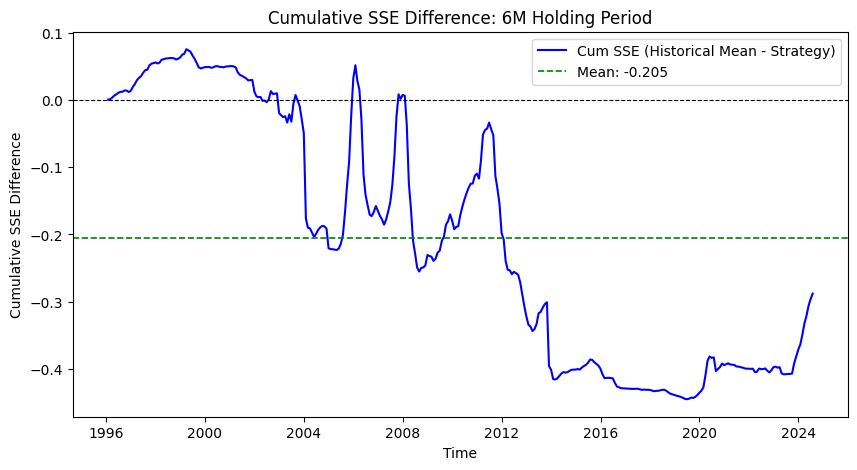

In [173]:
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df['Cum_SSE_difference'], label="Cum SSE (Historical Mean - Strategy)", color='blue')
plt.xlabel("Time")

#mean value
mean_value = results_df['Cum_SSE_difference'][:].mean()
plt.axhline(y=mean_value, color='green', linestyle='--', linewidth=1.2, label=f"Mean: {mean_value:.3f}")

plt.ylabel("Cumulative SSE Difference")
plt.title(f"Cumulative SSE Difference: {fwd_ret_period}M Holding Period")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.show()

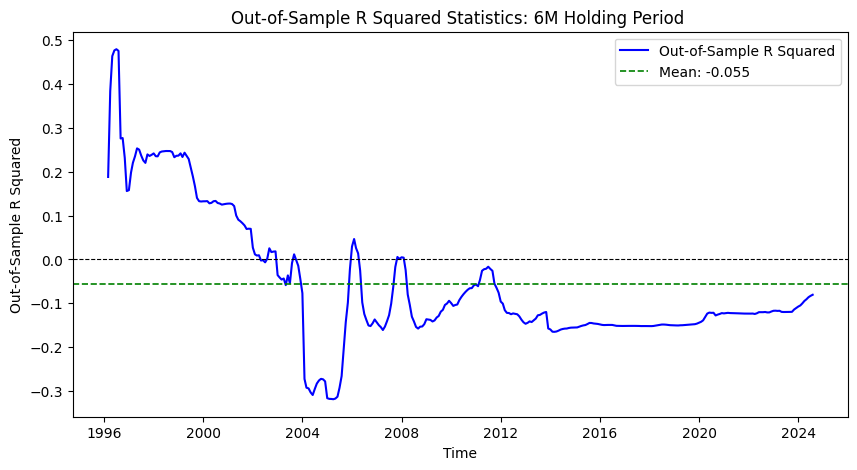

In [174]:
plt.figure(figsize=(10, 5))
plt.plot(results_df.iloc[1:].index, results_df['OOS_R_Sq'][1:], label="Out-of-Sample R Squared", color='blue') 
#omited the first data as it is noisy and makes the graph looks better to be explained in presentation, can change it back if we deep dive

#mean value of OOS R Sq
mean_value = results_df['OOS_R_Sq'][:].mean()
plt.axhline(y=mean_value, color='green', linestyle='--', linewidth=1.2, label=f"Mean: {mean_value:.3f}")

plt.xlabel("Time")
plt.ylabel("Out-of-Sample R Squared")
plt.title(f"Out-of-Sample R Squared Statistics: {fwd_ret_period}M Holding Period ")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.show()

##### **<font color= #80a4dd>Checkpoint - 4.4: Export LASSO Model Result </font>**

In [175]:
results_df.to_excel(f"generated_dataframe/lasso_x1(std)x2(std)_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

results_df

,train_end,calib_start,calib_end,test_date,best_alpha,forecast,realized,calib_error,GC1_1M_Ret,GC1_3M_Ret,...,Indian_premium_discount,PPI,hist_mean,SSE_hist,SSE_forecast,SSE_difference,Cum_SSE_difference,Cum_SSE_hist,Cum_SSE_forecast,OOS_R_Sq
test_date,,,,,,,,,,,,,,,,,,,,,
1996-01-31,1990-12-31,1991-01-31,1995-12-31,1996-01-31,0.010000,0.013334,-0.018734,0.003466,-0.0,0.0,...,0.0,-0.015895,0.020510,0.001540,0.001028,0.000512,0.000512,0.001540,0.001028,0.332292
1996-02-29,1991-01-31,1991-02-28,1996-01-31,1996-02-29,0.010000,0.015708,-0.047490,0.003345,-0.0,0.0,...,0.0,-0.015822,0.020663,0.004645,0.003994,0.000651,0.001163,0.006185,0.005022,0.187968
1996-03-31,1991-02-28,1991-03-31,1996-02-29,1996-03-31,0.010000,-0.008654,-0.034305,0.003402,-0.0,0.0,...,0.0,-0.015611,0.020748,0.003031,0.000658,0.002373,0.003535,0.009216,0.005680,0.383628
1996-04-30,1991-03-31,1991-04-30,1996-03-31,1996-04-30,0.010000,-0.005596,-0.048633,0.003374,-0.0,0.0,...,0.0,-0.015401,0.020782,0.004818,0.001852,0.002966,0.006502,0.014034,0.007532,0.463271
1996-05-31,1991-04-30,1991-05-31,1996-04-30,1996-05-31,0.010000,0.002112,-0.038903,0.003382,-0.0,0.0,...,0.0,-0.015180,0.020786,0.003563,0.001682,0.001880,0.008382,0.017597,0.009215,0.476340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,2019-02-28,2019-03-31,2024-02-29,2024-03-31,0.006700,0.085342,0.196326,0.009288,-0.0,0.0,...,0.0,-0.000985,0.025213,0.029280,0.012317,0.016962,-0.332709,3.519023,3.851732,-0.094546
2024-04-30,2019-03-31,2019-04-30,2024-03-31,2024-04-30,0.007163,0.071970,0.171135,0.009542,-0.0,0.0,...,-0.0,-0.000210,0.025481,0.021215,0.009834,0.011381,-0.321327,3.540238,3.861565,-0.090764
2024-05-31,2019-04-30,2019-05-31,2024-04-30,2024-05-31,0.007163,0.090039,0.175570,0.009657,-0.0,0.0,...,-0.0,-0.000354,0.025682,0.022467,0.007316,0.015151,-0.306176,3.562704,3.868881,-0.085939


## <font color="yellow"> IV. Random Forest Model (with LASSO Feature Selection) for Prediction</font>

##### **<font color= #90EE90>5.1: Random Forest - Feautres Selection from LASSO</font>**

**Narrow down features shorlisted by LASSO**

In [176]:
testing_start_date=pd.to_datetime(results_df['test_date'].iloc[0])
# Convert 'test_date' column to datetime type and set it as index
results_df["test_date"] = pd.to_datetime(results_df["test_date"])
results_df.set_index("test_date", drop=False, inplace=True)

# Get the index position of 'calib_error' column
calib_error_index = results_df.columns.get_loc("calib_error")
PPI_index = results_df.columns.get_loc("PPI")

# Extract all columns after 'calib_error'
LASSO_features_df = results_df.iloc[:, calib_error_index + 1: PPI_index + 1]
# Replace 0 with NA since our code using NA value to determine whether a feature is selected
LASSO_features_df.replace(0, pd.NA, inplace=True)
# Replace NA with 0 to help Random Forest to use up all the regressors (without LASSO selection)
all_features_df=LASSO_features_df.fillna(0)
LASSO_features_df.to_excel(f'generated_dataframe/checking_LASSO_features_df_{file_generation_date}.xlsx')

#check what features are selected
LASSO_features_df

,GC1_1M_Ret,GC1_3M_Ret,GC1_6M_Ret,GC1_12M_Ret,const,SPX Index,NDX Index,DXY Curncy,USGG10YR Index,USGG2YR Index,...,GDP_Nominoal_YOY,GDP_Real_QoQ,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,ETF_Ounces,Chinese_premium_discount,Indian_premium_discount,PPI
test_date,,,,,,,,,,,,,,,,,,,,,
1996-01-31,<NA>,<NA>,0.018351,0.020039,<NA>,<NA>,0.001055,<NA>,-0.006139,-0.007349,...,0.029132,-0.002391,-0.018247,<NA>,-0.000467,<NA>,<NA>,<NA>,<NA>,-0.015895
1996-02-29,<NA>,<NA>,0.018300,0.019985,<NA>,<NA>,0.001162,<NA>,-0.006047,-0.007297,...,0.029238,-0.002372,-0.01802,<NA>,-0.000461,<NA>,<NA>,<NA>,<NA>,-0.015822
1996-03-31,<NA>,<NA>,0.018193,0.019813,<NA>,<NA>,0.000814,<NA>,-0.007126,-0.006177,...,0.029437,-0.00231,-0.017667,<NA>,-0.000489,<NA>,<NA>,<NA>,<NA>,-0.015611
1996-04-30,<NA>,<NA>,0.018182,0.019706,<NA>,<NA>,0.000615,<NA>,-0.007444,-0.005962,...,0.029432,-0.002151,-0.017479,<NA>,-0.000482,<NA>,<NA>,<NA>,<NA>,-0.015401
1996-05-31,<NA>,<NA>,0.018063,0.019753,<NA>,<NA>,0.00072,<NA>,-0.007373,-0.006143,...,0.029565,-0.002037,-0.017183,<NA>,-0.000397,<NA>,<NA>,<NA>,<NA>,-0.01518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,<NA>,<NA>,0.001278,0.023088,<NA>,<NA>,<NA>,<NA>,-0.005797,<NA>,...,0.002906,-0.000172,-0.004038,-0.001004,<NA>,<NA>,<NA>,0.005388,<NA>,-0.000985
2024-04-30,<NA>,<NA>,0.001466,0.022151,<NA>,<NA>,<NA>,<NA>,-0.005358,<NA>,...,0.00141,<NA>,-0.00367,<NA>,<NA>,<NA>,<NA>,0.005853,<NA>,-0.00021
2024-05-31,<NA>,<NA>,0.001895,0.021936,<NA>,<NA>,<NA>,<NA>,-0.005344,<NA>,...,0.001449,<NA>,-0.003759,<NA>,<NA>,<NA>,<NA>,0.006107,<NA>,-0.000354


In [177]:
#Y.loc['1996-01-31':'1997-12-31']

In [178]:
#X.loc['1996-01-31':'1997-12-31']

##### **<font color= #90EE90>5.2: Random Forest - Build Model</font>**

**Parameters before loop**

In [179]:
#y_historical_mean_data=gc_data[f'{GC_type}_Monthly_Excess_Return'].loc[Y.index].dropna(how='all') #not used now

# Record the cumulative sum of SSE
SSE_model_cumsum = []
SSE_historical_cumsum = []
# Store the feature importance of every step
feature_importance_per_step = []
# Use Random Forest for prediction
model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=10,min_samples_split=5,max_features=0.6)  #random forest
# Record the actual value, the value predicted by our strategy and historical_mean_strategy
forest_results = []
# Get the index position
index_position = Y.index.get_loc(testing_start_date)
# Store the summaries of model
model_summaries = []

In [180]:
#Check how to use historical mean for random forest
print(hist_mean.loc['1996-01-31'])
print(hist_mean.loc['1996-01-31','hist_mean'])

hist_mean    0.02051
Name: 1996-01-31 00:00:00, dtype: float64
0.02051009426831697


**For Loop Iteration**

In [181]:
#Sicheng: Use for loop for train-test split

for t in tqdm(range(index_position, n_obs), desc=f"Processing"):
    # Use all the value to train up to time t
    X_train = X.iloc[:t]
    y_train = Y.iloc[:t]
    
    
    
    # Get the next step t+1
    X_test = X.iloc[t:t+1]
    y_actual = Y.iloc[t:t+1]
    y_actual = y_actual.iloc[0]
    # When the testing start
    current_date = Y.index[t]
    
    #print(hist_mean)
    #print(X_test.index[-1])
    
    #y_historical_mean = y_historical_mean_data.iloc[:t] #no longer used as it has been defined in the lasso stage
    y_historical_mean = hist_mean.loc[X_test.index[-1],'hist_mean'] #Align form previous selection. It only generate the hsitorical mean of that timepoint
    
    
    # Get the variables that are picked up by LASSO (those are not NA)
    selected_features = LASSO_features_df.loc[current_date].dropna().index.tolist()
    #selected_features = all_features_df.loc[current_date].dropna().index.tolist() #get index names from a series
    
    
    # selected only the features that have been picked up by LASSO 
    if len(selected_features) > 0:
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Train the regression model
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)[0]  # Get the single predicted value
        # Get the feature importance
        if hasattr(model, "feature_importances_"):  
            feature_importance = model.feature_importances_
        else:
            print("Feature_importance_error")

        # Record the feature importance of this time step
        feature_importance_per_step.append({
            "Date": current_date,  # record the date
            **dict(zip(selected_features, feature_importance))
        })
        
        # calculate the forecasting error of our strategy
        forecast_error = float(y_actual - y_pred)
    else:
        # If LASSO selected no features, take the expanding historical mean as prediction and it will also be used as error.
        # Actually it never happens because the num of selected features is 0. So no further study to judge whether this approach is good or not until other priorities are done.
        forecast_error = float(y_actual -  y_historical_mean)

    # Calculate the error of using a rolling historical mean to predict (benchmark error) 
    historical_mean_error = float(y_actual -  y_historical_mean)

    # Calculate the SSE 
    if t == index_position: #1st iteration
        SSE_model_cumsum.append(forecast_error ** 2)
        SSE_historical_cumsum.append(historical_mean_error ** 2)
    else:
        SSE_model_cumsum.append(SSE_model_cumsum[-1] + forecast_error ** 2) #After 1st iteration
        SSE_historical_cumsum.append(SSE_historical_cumsum[-1] + historical_mean_error ** 2) 
        
     # Record the result for every step
    forest_results.append({
        "Date": Y.index[t],
        "ret_real": float(y_actual),
        "ret_pred": float(y_pred),
        "historical_mean":  y_historical_mean,
        "SSE_hist": historical_mean_error,
        "SSE_forecast": forecast_error,
        "SSE_difference": historical_mean_error - forecast_error
    })
    
forest_results=pd.DataFrame(forest_results)
Cum_SSE_diff_series = np.array(SSE_historical_cumsum)  - np.array(SSE_model_cumsum)



Processing: 100%|██████████| 343/343 [00:27<00:00, 12.59it/s]


##### **<font color= #90EE90>5.3: Random Forest - Evaluate the Model Results</font>**

**Feature Importance Analysis**

In [182]:
df_feature_importance_per_step = pd.DataFrame(feature_importance_per_step)

# calculate the mean value for the feature importance of all the features
df_feature_avg_importance = df_feature_importance_per_step.mean().reset_index()
df_feature_avg_importance.columns = ["Feature", "Avg Importance"]

df_feature_avg_importance.set_index("Feature",inplace=True)

counts = df_feature_importance_per_step[df_feature_importance_per_step.columns].count()
counts.drop('Date',inplace=True)

df_feature_avg_importance['counts'] = counts
df_feature_avg_importance=df_feature_avg_importance[1:]


df_feature_avg_importance


,Avg Importance,counts
Feature,,
GC1_6M_Ret,0.161817,343.0
GC1_12M_Ret,0.212672,343.0
NDX Index,0.007676,24.0
USGG10YR Index,0.075196,272.0
USGG2YR Index,0.039588,174.0
JPY Curncy,0.034542,176.0
GDP_Nominoal_YOY,0.198032,258.0
GDP_Real_QoQ,0.091118,174.0
US_Unemp,0.161611,261.0


In [183]:
# This is the feature importance for each of the steps
df_feature_importance_per_step.set_index("Date", inplace=True)
df_feature_importance_per_step.tail(10)

,GC1_6M_Ret,GC1_12M_Ret,NDX Index,USGG10YR Index,USGG2YR Index,JPY Curncy,GDP_Nominoal_YOY,GDP_Real_QoQ,US_Unemp,US_RIR,...,Chinese_premium_discount,PE_RATIO,Fed_Eff_Rate,CPI YOY Index,PCE CYOY Index,GC1_3M_Ret,D/P Ratio,1M_risk_free_ret_realized,DXY Curncy,Indian_premium_discount
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-31,0.083153,0.123794,NaN,0.041636,NaN,NaN,0.145502,0.109860,0.138978,NaN,...,0.029609,NaN,NaN,NaN,0.265713,NaN,NaN,NaN,NaN,NaN
2023-11-30,0.079226,0.111690,NaN,0.032690,NaN,NaN,0.113828,0.110134,0.118346,NaN,...,0.028190,NaN,NaN,NaN,0.265004,NaN,NaN,NaN,NaN,NaN
2023-12-31,0.075759,0.116930,NaN,0.031540,NaN,NaN,0.107167,0.109812,0.121548,NaN,...,0.029959,NaN,NaN,NaN,0.268826,NaN,NaN,NaN,NaN,NaN
2024-01-31,0.074482,0.116255,NaN,0.030837,NaN,NaN,0.106478,0.111744,0.125038,NaN,...,0.029892,NaN,NaN,NaN,0.267483,NaN,NaN,NaN,NaN,NaN
2024-02-29,0.074552,0.111785,NaN,0.031533,NaN,NaN,0.109403,0.106861,0.133579,NaN,...,0.027043,NaN,NaN,NaN,0.266607,NaN,NaN,NaN,NaN,NaN
2024-03-31,0.074590,0.116072,NaN,0.031275,NaN,NaN,0.109602,0.104426,0.131279,NaN,...,0.026548,NaN,NaN,NaN,0.268969,NaN,NaN,NaN,NaN,NaN
2024-04-30,0.116570,0.181192,NaN,0.066338,NaN,NaN,0.205138,NaN,0.208594,NaN,...,0.060659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31,0.116196,0.174675,NaN,0.065658,NaN,NaN,0.205995,NaN,0.215067,NaN,...,0.057988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,0.120820,0.179803,NaN,0.062835,NaN,NaN,0.207417,NaN,0.202618,NaN,...,0.058827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
# This is the average feature importance of all the time steps
df_feature_avg_importance

,Avg Importance,counts
Feature,,
GC1_6M_Ret,0.161817,343.0
GC1_12M_Ret,0.212672,343.0
NDX Index,0.007676,24.0
USGG10YR Index,0.075196,272.0
USGG2YR Index,0.039588,174.0
JPY Curncy,0.034542,176.0
GDP_Nominoal_YOY,0.198032,258.0
GDP_Real_QoQ,0.091118,174.0
US_Unemp,0.161611,261.0


**Random Forest Results**

In [185]:
# forest_results.drop('Cum_SSE_Diff',axis=1, inplace=True)
# forest_results

In [186]:
# This is the resulting dataframe of the random forest
forest_results.set_index(forest_results['Date'],drop=True, inplace=True)

forest_results

,Date,ret_real,ret_pred,historical_mean,SSE_hist,SSE_forecast,SSE_difference
Date,,,,,,,
1996-01-31,1996-01-31,-0.018734,0.000474,0.020510,-0.039244,-0.019208,-0.020036
1996-02-29,1996-02-29,-0.047490,-0.012787,0.020663,-0.068152,-0.034703,-0.033450
1996-03-31,1996-03-31,-0.034305,-0.002596,0.020748,-0.055052,-0.031708,-0.023344
1996-04-30,1996-04-30,-0.048633,-0.002741,0.020782,-0.069415,-0.045893,-0.023522
1996-05-31,1996-05-31,-0.038903,-0.011952,0.020786,-0.059689,-0.026951,-0.032738
...,...,...,...,...,...,...,...
2024-03-31,2024-03-31,0.196326,0.097855,0.025213,0.171113,0.098471,0.072642
2024-04-30,2024-04-30,0.171135,0.057158,0.025481,0.145654,0.113977,0.031677
2024-05-31,2024-05-31,0.175570,0.110185,0.025682,0.149889,0.065385,0.084503


**Cumulative SSE Difference**

In [187]:
##SSE Difference
RF_SSE_diff_df = pd.DataFrame(forest_results['SSE_difference'])
RF_SSE_diff_df = RF_SSE_diff_df.set_index(df_feature_importance_per_step.index)
RF_SSE_diff_df

,SSE_difference
Date,
1996-01-31,-0.020036
1996-02-29,-0.033450
1996-03-31,-0.023344
1996-04-30,-0.023522
1996-05-31,-0.032738
...,...
2024-03-31,0.072642
2024-04-30,0.031677
2024-05-31,0.084503


In [188]:
RF_Cum_SSE_diff_df = pd.DataFrame(Cum_SSE_diff_series,index=df_feature_importance_per_step.index,columns=['Cum_SSE_Diff'] )
forest_results = forest_results.join(RF_Cum_SSE_diff_df,how="left")

forest_results

,Date,ret_real,ret_pred,historical_mean,SSE_hist,SSE_forecast,SSE_difference,Cum_SSE_Diff
Date,,,,,,,,
1996-01-31,1996-01-31,-0.018734,0.000474,0.020510,-0.039244,-0.019208,-0.020036,0.001171
1996-02-29,1996-02-29,-0.047490,-0.012787,0.020663,-0.068152,-0.034703,-0.033450,0.004612
1996-03-31,1996-03-31,-0.034305,-0.002596,0.020748,-0.055052,-0.031708,-0.023344,0.006637
1996-04-30,1996-04-30,-0.048633,-0.002741,0.020782,-0.069415,-0.045893,-0.023522,0.009349
1996-05-31,1996-05-31,-0.038903,-0.011952,0.020786,-0.059689,-0.026951,-0.032738,0.012186
...,...,...,...,...,...,...,...,...
2024-03-31,2024-03-31,0.196326,0.097855,0.025213,0.171113,0.098471,0.072642,0.792910
2024-04-30,2024-04-30,0.171135,0.057158,0.025481,0.145654,0.113977,0.031677,0.801134
2024-05-31,2024-05-31,0.175570,0.110185,0.025682,0.149889,0.065385,0.084503,0.819326


**Plot Cumulative SSE**

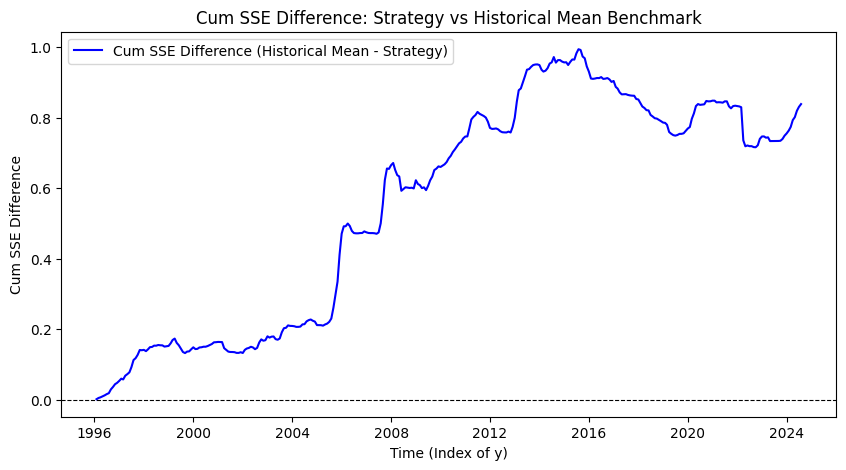

In [189]:

# Plot the cumulative SSE 
plt.figure(figsize=(10, 5))
plt.plot(Y.index[index_position:n_obs], Cum_SSE_diff_series, label="Cum SSE Difference (Historical Mean - Strategy)", color='blue')

plt.xlabel("Time (Index of y)")
plt.ylabel("Cum SSE Difference")
plt.title("Cum SSE Difference: Strategy vs Historical Mean Benchmark")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # add the 0 baseline
plt.legend()
plt.show()

##### **<font color= #80a4dd>Checkpoint - 5.4: Random Forest - Export Dataframe Results</font>**

In [190]:
df_feature_importance_per_step.to_excel(f"generated_dataframe/forest_SelFeatures_df_feature_importance_per_step_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

In [191]:
forest_results_df = forest_results.join(df_feature_importance_per_step,how="left")

In [192]:
forest_results_df.to_excel(f"generated_dataframe/forest_SelFeatures_results_df__{GC_type}_{fwd_ret_period}M_{file_generation_date}_.xlsx")

forest_results_df

,Date,ret_real,ret_pred,historical_mean,SSE_hist,SSE_forecast,SSE_difference,Cum_SSE_Diff,GC1_6M_Ret,GC1_12M_Ret,...,Chinese_premium_discount,PE_RATIO,Fed_Eff_Rate,CPI YOY Index,PCE CYOY Index,GC1_3M_Ret,D/P Ratio,1M_risk_free_ret_realized,DXY Curncy,Indian_premium_discount
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-31,1996-01-31,-0.018734,0.000474,0.020510,-0.039244,-0.019208,-0.020036,0.001171,0.088864,0.121315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-29,1996-02-29,-0.047490,-0.012787,0.020663,-0.068152,-0.034703,-0.033450,0.004612,0.088777,0.112913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-31,1996-03-31,-0.034305,-0.002596,0.020748,-0.055052,-0.031708,-0.023344,0.006637,0.088615,0.112111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-30,1996-04-30,-0.048633,-0.002741,0.020782,-0.069415,-0.045893,-0.023522,0.009349,0.088416,0.112945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-31,1996-05-31,-0.038903,-0.011952,0.020786,-0.059689,-0.026951,-0.032738,0.012186,0.088507,0.112030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,2024-03-31,0.196326,0.097855,0.025213,0.171113,0.098471,0.072642,0.792910,0.074590,0.116072,...,0.026548,NaN,NaN,NaN,0.268969,NaN,NaN,NaN,NaN,NaN
2024-04-30,2024-04-30,0.171135,0.057158,0.025481,0.145654,0.113977,0.031677,0.801134,0.116570,0.181192,...,0.060659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31,2024-05-31,0.175570,0.110185,0.025682,0.149889,0.065385,0.084503,0.819326,0.116196,0.174675,...,0.057988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Placeholder - no longer used, abandoned

**Calculate OOS R-Squared**

In [193]:
# forest_Cum_SSE_hist = forest_results['SSE_hist'].expanding(min_periods=1).sum()
# forest_Cum_SSE_forecast = forest_results['SSE_forecast'].expanding(min_periods=1).sum()

# forest_results['OOS_R_Sq'] = 1 - (forest_Cum_SSE_forecast / forest_Cum_SSE_hist)

# forest_results

**Plot OOS R Squared (Placeholder)**

In [194]:
# plt.figure(figsize=(10, 5))

# filter_OOS_R_Sq = np.where(abs(forest_results['OOS_R_Sq'][1:])>1,np.nan,forest_results['OOS_R_Sq'][1:])


# plt.plot(forest_results.iloc[1:].index,filter_OOS_R_Sq , label="Out-of-Sample R Squared", color='blue') 
# #omited the first data as it is noisy and makes the graph looks better to be explained in presentation, can change it back if we deep dive

# #mean value of OOS R Sq
# mean_value = forest_results['OOS_R_Sq'][:].mean()
# plt.axhline(y=mean_value, color='green', linestyle='--', linewidth=1.2, label=f"Mean: {mean_value:.3f}")

# plt.xlabel("Time")
# plt.ylabel("Out-of-Sample R Squared")
# plt.title(f"Out-of-Sample R Squared Statistics: {fwd_ret_period}M Holding Period ")
# plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
# plt.legend()
# plt.show()

In [195]:
# plt.figure(figsize=(10, 5))

# #filter_OOS_R_Sq = np.where(abs(forest_results['OOS_R_Sq'][1:])>1,np.nan,forest_results['OOS_R_Sq'][1:])


# plt.plot(forest_results.iloc[1:].index,forest_results['OOS_R_Sq'][1:], label="Out-of-Sample R Squared", color='blue') 
# #omited the first data as it is noisy and makes the graph looks better to be explained in presentation, can change it back if we deep dive

# #mean value of OOS R Sq
# mean_value = forest_results['OOS_R_Sq'][:].mean()
# plt.axhline(y=mean_value, color='green', linestyle='--', linewidth=1.2, label=f"Mean: {mean_value:.3f}")

# plt.xlabel("Time")
# plt.ylabel("Out-of-Sample R Squared")
# plt.title(f"Out-of-Sample R Squared Statistics: {fwd_ret_period}M Holding Period ")
# plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
# plt.legend()
# plt.show()

## <font color="yellow"> V. Random Forest Model (All Features Included) for Prediction</font>

##### **<font color= #90EE90>6.1: Random Forest (All Features) - Paremters Tuning (if any)</font>**

##### **<font color= #90EE90>6.2: Random Forest (All Features) - Build Model</font>**

In [196]:
#y_historical_mean_data=gc_data[f'{GC_type}_Monthly_Excess_Return'].loc[Y.index].dropna(how='all') #not used now

# Record the cumulative sum of SSE
forest_all_SSE_model_cumsum = []
forest_all_SSE_historical_cumsum = []
# Store the feature importance of every step
forest_all_feature_importance_per_step = []
# Use Random Forest for prediction
forest_all_model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=10,min_samples_split=5,max_features=0.6)  #random forest
# Record the actual value, the value predicted by our strategy and historical_mean_strategy
forest_all_results = []
# Get the index position
forest_all_index_position = Y.index.get_loc(testing_start_date)
# Store the summaries of model
forest_all_model_summaries = []

**For Loop Iteration**

In [197]:
#Sicheng: Use for loop for train-test split

for t in tqdm(range(index_position, n_obs), desc=f"Processing"):
    # Use all the value to train up to time t
    X_train = X.iloc[:t]
    y_train = Y.iloc[:t]
    
    
    # Get the next step t+1
    X_test = X.iloc[t:t+1]
    y_actual = Y.iloc[t:t+1]
    y_actual = y_actual.iloc[0]
    # When the testing start
    current_date = Y.index[t]
    
    #print(hist_mean)
    #print(X_test.index[-1])
    
    #y_historical_mean = y_historical_mean_data.iloc[:t] #no longer used as it has been defined in the lasso stage
    y_historical_mean = hist_mean.loc[X_test.index[-1],'hist_mean'] #Align form previous selection. It only generate the hsitorical mean of that timepoint
    
    
    # Get the variables that are picked up by LASSO (those are not NA)
    # selected_features = LASSO_features_df.loc[current_date].dropna().index.tolist()
    selected_features = all_features_df.loc[current_date].dropna().index.tolist() #get index names from a series
    
    
    # selected only the features that have been picked up by LASSO 
    if len(selected_features) > 0:
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Train the regression model
        forest_all_model.fit(X_train_selected, y_train)
        y_pred = forest_all_model.predict(X_test_selected)[0]  # Get the single predicted value
        # Get the feature importance
        if hasattr(forest_all_model, "feature_importances_"):  
            forest_all_feature_importance = forest_all_model.feature_importances_
        else:
            print("Feature_importance_error")

        # Record the feature importance of this time step
        forest_all_feature_importance_per_step.append({
            "Date": current_date,  # record the date
            **dict(zip(selected_features, forest_all_feature_importance))
        })
        
        # calculate the forecasting error of our strategy
        forecast_error = float(y_actual - y_pred)
    else:
        # If LASSO selected no features, take the expanding historical mean as prediction and it will also be used as error.
        # Actually it never happens because the num of selected features is 0. So no further study to judge whether this approach is good or not until other priorities are done.
        forecast_error = float(y_actual -  y_historical_mean)

    # Calculate the error of using a rolling historical mean to predict (benchmark error) 
    historical_mean_error = float(y_actual -  y_historical_mean)

    # Calculate the SSE 
    if t == index_position: #1st iteration
        forest_all_SSE_model_cumsum.append(forecast_error ** 2)
        forest_all_SSE_historical_cumsum.append(historical_mean_error ** 2)
    else:
        forest_all_SSE_model_cumsum.append(forest_all_SSE_model_cumsum[-1] + forecast_error ** 2) #After 1st iteration
        forest_all_SSE_historical_cumsum.append(forest_all_SSE_historical_cumsum[-1] + historical_mean_error ** 2) 
        
     # Record the result for every step
    forest_all_results.append({
        "Date": Y.index[t],
        "ret_real": float(y_actual),
        "ret_pred": float(y_pred),
        "historical_mean":  y_historical_mean,
        "SSE_hist": historical_mean_error,
        "SSE_forecast": forecast_error,
        "SSE_difference": historical_mean_error - forecast_error
    })
    
forest_all_results=pd.DataFrame(forest_all_results)
forest_all_Cum_SSE_diff_series = np.array(forest_all_SSE_historical_cumsum)  - np.array(forest_all_SSE_model_cumsum)



Processing: 100%|██████████| 343/343 [00:59<00:00,  5.80it/s]


In [198]:
forest_all_results

,Date,ret_real,ret_pred,historical_mean,SSE_hist,SSE_forecast,SSE_difference
0,1996-01-31,-0.018734,0.010167,0.020510,-0.039244,-0.028901,-0.010343
1,1996-02-29,-0.047490,-0.002736,0.020663,-0.068152,-0.044754,-0.023399
2,1996-03-31,-0.034305,0.005293,0.020748,-0.055052,-0.039598,-0.015455
3,1996-04-30,-0.048633,-0.000690,0.020782,-0.069415,-0.047944,-0.021471
4,1996-05-31,-0.038903,0.001934,0.020786,-0.059689,-0.040836,-0.018852
...,...,...,...,...,...,...,...
338,2024-03-31,0.196326,0.070553,0.025213,0.171113,0.125773,0.045340
339,2024-04-30,0.171135,0.060405,0.025481,0.145654,0.110730,0.034924
340,2024-05-31,0.175570,0.091901,0.025682,0.149889,0.083669,0.066220
341,2024-06-30,0.132616,0.094396,0.025859,0.106756,0.038220,0.068537


##### **<font color= #90EE90>6.3: Random Forest (All Features) - Evaluate the Model Results</font>**

**Feature Importance Analysis**

In [199]:
forest_all_df_feature_importance_per_step = pd.DataFrame(forest_all_feature_importance_per_step)
forest_all_df_feature_importance_per_step

# calculate the mean value for the feature importance of all the features
forest_all_df_feature_avg_importance = forest_all_df_feature_importance_per_step.mean().reset_index()
forest_all_df_feature_avg_importance.columns = ["Feature", "Avg Importance"]

forest_all_df_feature_avg_importance.set_index("Feature",inplace=True)

forest_all_counts = forest_all_df_feature_importance_per_step[forest_all_df_feature_importance_per_step.columns].count()
forest_all_counts.drop('Date',inplace=True)

forest_all_df_feature_avg_importance['counts'] = forest_all_counts
forest_all_df_feature_avg_importance=forest_all_df_feature_avg_importance[1:]


forest_all_df_feature_avg_importance

,Avg Importance,counts
Feature,,
GC1_1M_Ret,0.022633,343.0
GC1_3M_Ret,0.022199,343.0
GC1_6M_Ret,0.055469,343.0
GC1_12M_Ret,0.077637,343.0
const,0.0,343.0
SPX Index,0.010665,343.0
NDX Index,0.004543,343.0
DXY Curncy,0.013916,343.0
USGG10YR Index,0.011944,343.0


In [200]:
# This is the feature importance for each of the steps
forest_all_df_feature_importance_per_step.set_index("Date", inplace=True)
forest_all_df_feature_importance_per_step.tail(10)

,GC1_1M_Ret,GC1_3M_Ret,GC1_6M_Ret,GC1_12M_Ret,const,SPX Index,NDX Index,DXY Curncy,USGG10YR Index,USGG2YR Index,...,GDP_Nominoal_YOY,GDP_Real_QoQ,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,ETF_Ounces,Chinese_premium_discount,Indian_premium_discount,PPI
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-31,0.019799,0.018365,0.050769,0.066682,0.0,0.013409,0.005547,0.014582,0.012906,0.016418,...,0.090479,0.072112,0.078258,0.026866,0.052338,0.027510,0.025690,0.010874,0.006900,0.043929
2023-11-30,0.018047,0.017366,0.045149,0.072969,0.0,0.011953,0.005099,0.014419,0.013244,0.016394,...,0.084483,0.073738,0.085200,0.031624,0.049903,0.028778,0.024920,0.012612,0.006337,0.043165
2023-12-31,0.020194,0.021381,0.046183,0.070720,0.0,0.011734,0.005945,0.014069,0.013962,0.016010,...,0.084507,0.072419,0.080534,0.030348,0.056119,0.028504,0.022933,0.011838,0.005221,0.046644
2024-01-31,0.020222,0.017857,0.047951,0.071052,0.0,0.011183,0.006998,0.014031,0.012029,0.017125,...,0.080118,0.070845,0.079640,0.031186,0.051248,0.031404,0.023781,0.012142,0.005532,0.045979
2024-02-29,0.019576,0.018115,0.045615,0.073972,0.0,0.013862,0.006534,0.014333,0.012691,0.018204,...,0.079469,0.072966,0.079308,0.029305,0.052633,0.028962,0.024370,0.012149,0.005406,0.045310
2024-03-31,0.019197,0.017474,0.049306,0.069871,0.0,0.013896,0.006914,0.014225,0.012630,0.017817,...,0.076929,0.076623,0.081661,0.030513,0.048582,0.027387,0.023442,0.012088,0.006044,0.046197
2024-04-30,0.019735,0.019576,0.045216,0.071123,0.0,0.011983,0.006811,0.014041,0.011088,0.015804,...,0.080808,0.075326,0.083285,0.032723,0.049528,0.027614,0.023596,0.013509,0.005404,0.044636
2024-05-31,0.019183,0.019028,0.046903,0.073643,0.0,0.013377,0.006023,0.014016,0.010635,0.015923,...,0.080556,0.071051,0.087917,0.033509,0.048689,0.030183,0.024646,0.012508,0.005824,0.043572
2024-06-30,0.020004,0.018519,0.044393,0.076996,0.0,0.010834,0.006199,0.012608,0.011990,0.014405,...,0.085312,0.069890,0.086903,0.032902,0.053234,0.028980,0.026719,0.013078,0.005455,0.041377


**Random Forest (All Feataures) Results**

In [201]:
forest_all_results.set_index(forest_all_results['Date'],drop=True, inplace=True)

forest_all_results

,Date,ret_real,ret_pred,historical_mean,SSE_hist,SSE_forecast,SSE_difference
Date,,,,,,,
1996-01-31,1996-01-31,-0.018734,0.010167,0.020510,-0.039244,-0.028901,-0.010343
1996-02-29,1996-02-29,-0.047490,-0.002736,0.020663,-0.068152,-0.044754,-0.023399
1996-03-31,1996-03-31,-0.034305,0.005293,0.020748,-0.055052,-0.039598,-0.015455
1996-04-30,1996-04-30,-0.048633,-0.000690,0.020782,-0.069415,-0.047944,-0.021471
1996-05-31,1996-05-31,-0.038903,0.001934,0.020786,-0.059689,-0.040836,-0.018852
...,...,...,...,...,...,...,...
2024-03-31,2024-03-31,0.196326,0.070553,0.025213,0.171113,0.125773,0.045340
2024-04-30,2024-04-30,0.171135,0.060405,0.025481,0.145654,0.110730,0.034924
2024-05-31,2024-05-31,0.175570,0.091901,0.025682,0.149889,0.083669,0.066220


**Cumulative SSE Difference**

In [202]:
##SSE Difference
RF_All_SSE_diff_df = pd.DataFrame(forest_all_results['SSE_difference'])
RF_All_SSE_diff_df = RF_All_SSE_diff_df.set_index(forest_all_df_feature_importance_per_step.index)
RF_All_SSE_diff_df

,SSE_difference
Date,
1996-01-31,-0.010343
1996-02-29,-0.023399
1996-03-31,-0.015455
1996-04-30,-0.021471
1996-05-31,-0.018852
...,...
2024-03-31,0.045340
2024-04-30,0.034924
2024-05-31,0.066220


In [203]:
RF_All_Cum_SSE_diff_df = pd.DataFrame(forest_all_Cum_SSE_diff_series,index=forest_all_df_feature_importance_per_step.index,columns=['Cum_SSE_Diff'] )
forest_all_results = forest_all_results.join(RF_All_Cum_SSE_diff_df,how="left")

forest_all_results

,Date,ret_real,ret_pred,historical_mean,SSE_hist,SSE_forecast,SSE_difference,Cum_SSE_Diff
Date,,,,,,,,
1996-01-31,1996-01-31,-0.018734,0.010167,0.020510,-0.039244,-0.028901,-0.010343,0.000705
1996-02-29,1996-02-29,-0.047490,-0.002736,0.020663,-0.068152,-0.044754,-0.023399,0.003347
1996-03-31,1996-03-31,-0.034305,0.005293,0.020748,-0.055052,-0.039598,-0.015455,0.004809
1996-04-30,1996-04-30,-0.048633,-0.000690,0.020782,-0.069415,-0.047944,-0.021471,0.007329
1996-05-31,1996-05-31,-0.038903,0.001934,0.020786,-0.059689,-0.040836,-0.018852,0.009224
...,...,...,...,...,...,...,...,...
2024-03-31,2024-03-31,0.196326,0.070553,0.025213,0.171113,0.125773,0.045340,0.805635
2024-04-30,2024-04-30,0.171135,0.060405,0.025481,0.145654,0.110730,0.034924,0.814588
2024-05-31,2024-05-31,0.175570,0.091901,0.025682,0.149889,0.083669,0.066220,0.830055


**Plot Cumulative SSE**

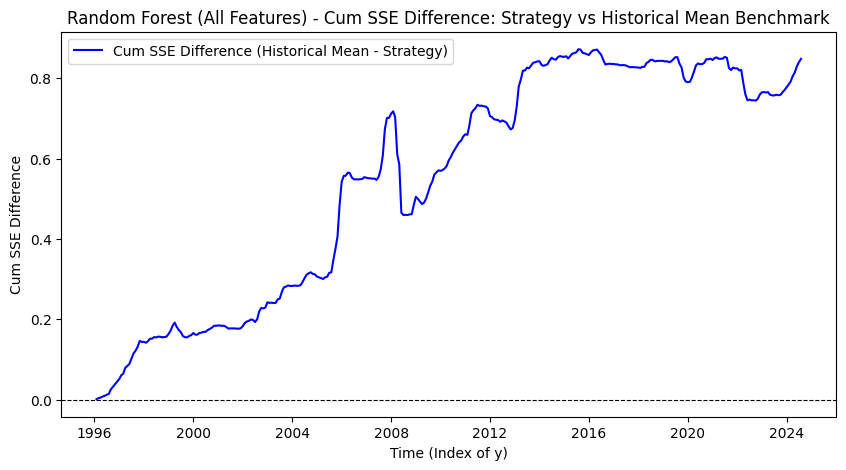

In [204]:
# Plot the cumulative SSE 
plt.figure(figsize=(10, 5))
plt.plot(Y.index[index_position:n_obs], forest_all_Cum_SSE_diff_series, label="Cum SSE Difference (Historical Mean - Strategy)", color='blue')

plt.xlabel("Time (Index of y)")
plt.ylabel("Cum SSE Difference")
plt.title("Random Forest (All Features) - Cum SSE Difference: Strategy vs Historical Mean Benchmark")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # add the 0 baseline
plt.legend()
plt.show()

##### **<font color= #80a4dd>Checkpoint - 6.4: Random Forest (All Features) - Export Dataframe Results</font>**

In [205]:
forest_all_df_feature_importance_per_step.to_excel(f"generated_dataframe/forest_All_df_feature_importance_per_step_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

In [206]:
forest_all_results_df = forest_all_results.join(forest_all_df_feature_importance_per_step,how="left")

In [207]:
forest_all_results_df.to_excel(f"generated_dataframe/forest_All_results_df__{GC_type}_{fwd_ret_period}M_{file_generation_date}_.xlsx")

forest_all_results_df

,Date,ret_real,ret_pred,historical_mean,SSE_hist,SSE_forecast,SSE_difference,Cum_SSE_Diff,GC1_1M_Ret,GC1_3M_Ret,...,GDP_Nominoal_YOY,GDP_Real_QoQ,US_Unemp,Cons_Conf,US_RIR,1M_risk_free_ret_realized,ETF_Ounces,Chinese_premium_discount,Indian_premium_discount,PPI
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-31,1996-01-31,-0.018734,0.010167,0.020510,-0.039244,-0.028901,-0.010343,0.000705,0.017664,0.019442,...,0.139813,0.039987,0.112964,0.029730,0.076665,0.016635,0.000000,0.000000,0.000000,0.055911
1996-02-29,1996-02-29,-0.047490,-0.002736,0.020663,-0.068152,-0.044754,-0.023399,0.003347,0.017620,0.018383,...,0.137274,0.041800,0.118474,0.027549,0.073246,0.015454,0.000000,0.000000,0.000000,0.053109
1996-03-31,1996-03-31,-0.034305,0.005293,0.020748,-0.055052,-0.039598,-0.015455,0.004809,0.018012,0.015601,...,0.140902,0.038323,0.119371,0.027809,0.077878,0.013091,0.000000,0.000000,0.000000,0.046821
1996-04-30,1996-04-30,-0.048633,-0.000690,0.020782,-0.069415,-0.047944,-0.021471,0.007329,0.018824,0.015908,...,0.149467,0.040124,0.112506,0.024220,0.075485,0.014535,0.000000,0.000000,0.000000,0.054253
1996-05-31,1996-05-31,-0.038903,0.001934,0.020786,-0.059689,-0.040836,-0.018852,0.009224,0.017899,0.016460,...,0.143283,0.045102,0.106750,0.025500,0.068359,0.016155,0.000000,0.000000,0.000000,0.063326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,2024-03-31,0.196326,0.070553,0.025213,0.171113,0.125773,0.045340,0.805635,0.019197,0.017474,...,0.076929,0.076623,0.081661,0.030513,0.048582,0.027387,0.023442,0.012088,0.006044,0.046197
2024-04-30,2024-04-30,0.171135,0.060405,0.025481,0.145654,0.110730,0.034924,0.814588,0.019735,0.019576,...,0.080808,0.075326,0.083285,0.032723,0.049528,0.027614,0.023596,0.013509,0.005404,0.044636
2024-05-31,2024-05-31,0.175570,0.091901,0.025682,0.149889,0.083669,0.066220,0.830055,0.019183,0.019028,...,0.080556,0.071051,0.087917,0.033509,0.048689,0.030183,0.024646,0.012508,0.005824,0.043572


## <font color="yellow"> VI. Trading Strategy</font>

##### **<font color= #90EE90>7.1 Trading Strategy Plot </font>**

In [208]:
# set the possible transaction cost to the strategy
transaction_cost=[0,0.001]
# We doesn't apply a transaction cost to the historical mean prediction benchmark
benchmark_bp=0.000
# only predicted excess return excess this benchmark will be taken long position to decrease the impact of noise
excess_ret_thershold=0.02
raw_df_al_risk_free_rate = raw_df_al_risk_free_rate.loc[testing_start_date:]
monthly_risk_free_rate=np.log(1+raw_df_al_risk_free_rate/1200)

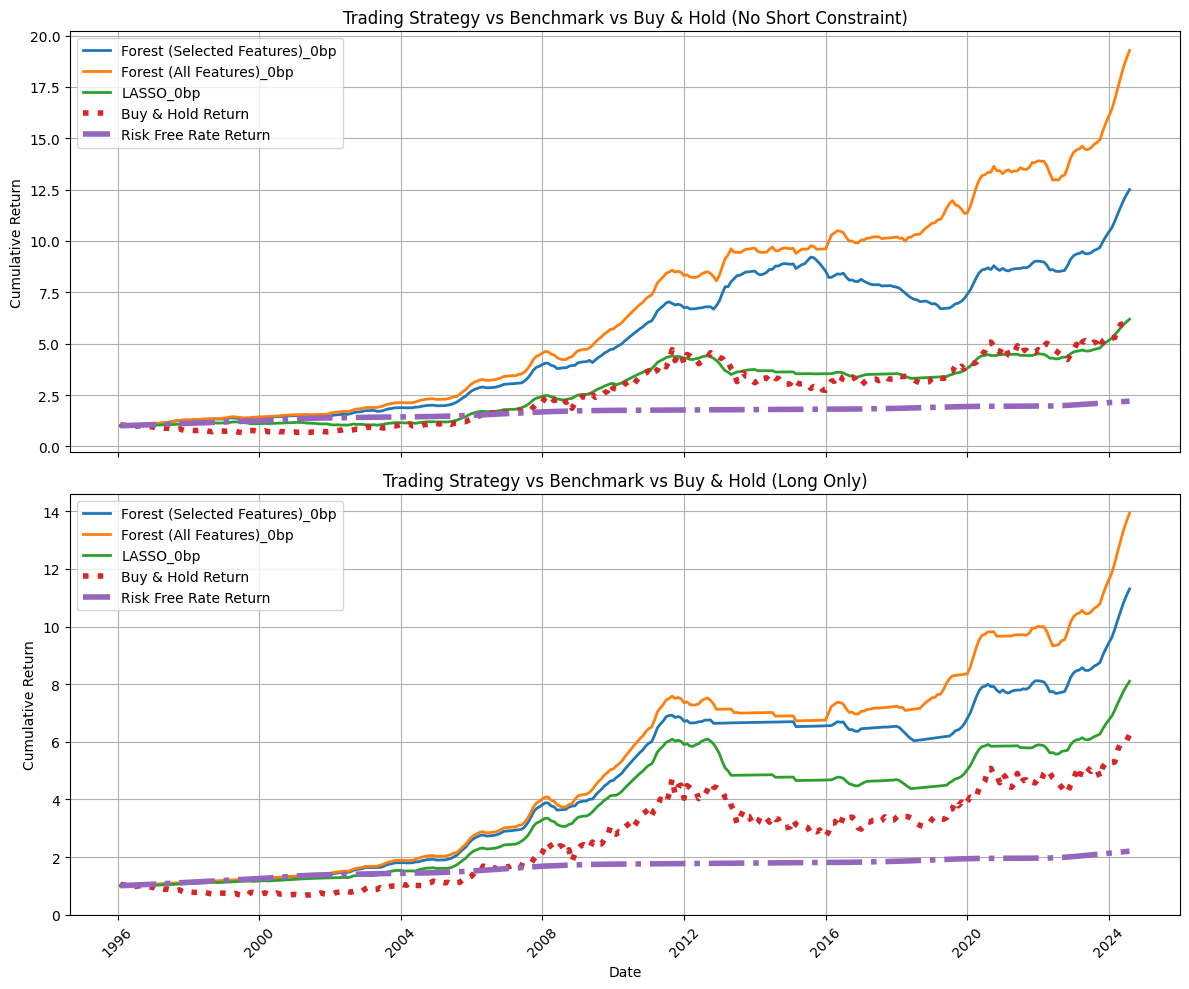

In [209]:
long_short_perf_dict,long_only_perf_dict = gpf2.trading_plot_2(
    gc_data,GC_type,fwd_ret_period,monthly_risk_free_rate,excess_ret_thershold,[forest_results, forest_all_results, LASSO_result],transaction_cost = [0], names = ["Forest (Selected Features)", "Forest (All Features)","LASSO"])

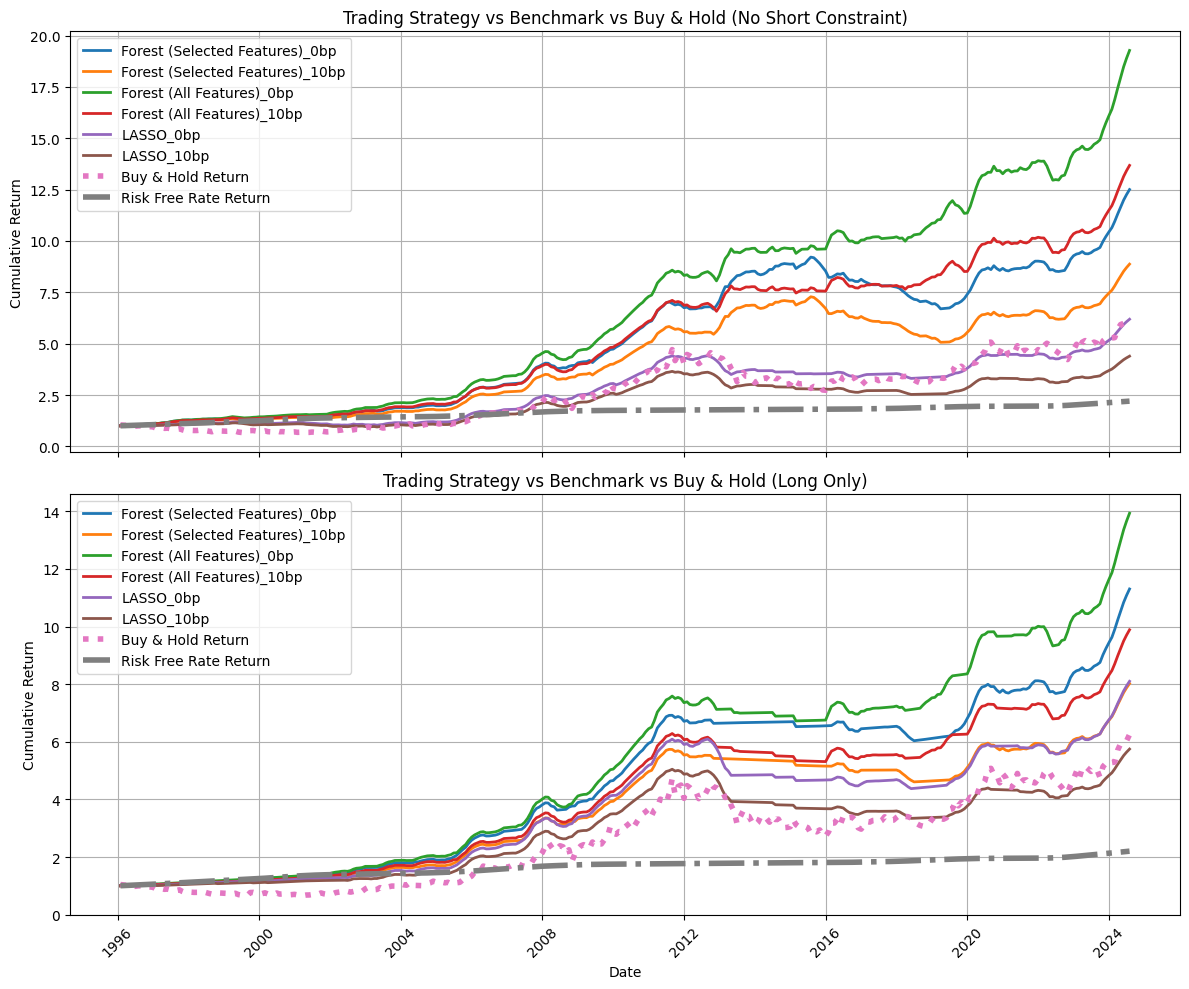

In [210]:
# Plot the cumulative return of random forest model
long_short_perf_dict,long_only_perf_dict = gpf2.trading_plot_2(
    gc_data,GC_type,fwd_ret_period,monthly_risk_free_rate,excess_ret_thershold,[forest_results,forest_all_results, LASSO_result],transaction_cost = [0,0.001], names = ["Forest (Selected Features)","Forest (All Features)", "LASSO"])

##### Generate more perf_dataframe

In [211]:
forest_SelF_long_short_perf = long_short_perf_dict["Forest (Selected Features)"]
forest_SelF_long_only_perf = long_only_perf_dict["Forest (Selected Features)"]
forest_All_long_short_perf = long_short_perf_dict["Forest (All Features)"]
forest_All_long_only_perf = long_only_perf_dict["Forest (All Features)"]
lasso_long_short_perf = long_short_perf_dict["LASSO"]
lasso_long_only_perf = long_only_perf_dict["LASSO"]


##### **<font color= #90EE90>7.2 Add Performance Metrics and Export Strategy Dataframe </font>**

In [212]:
# This method add performance matrices like max_drawdown and SSE difference (each step)
gpf.add_performance_matrices(lasso_long_short_perf)
gpf.add_performance_matrices(lasso_long_only_perf)
gpf.add_performance_matrices(forest_All_long_short_perf)
gpf.add_performance_matrices(forest_All_long_only_perf)
gpf.add_performance_matrices(forest_SelF_long_short_perf)
gpf.add_performance_matrices(forest_SelF_long_only_perf)

,ret_real,ret_pred,historical_mean,SSE_hist,SSE_forecast,SSE_difference,Cum_SSE_Diff,strategy_return_0bp,strategy_action,cumulative_strategy_0bp,...,cumulative_benchmark,cumulative_buy_and_hold,cumulative_risk_free,strategy_correct_guess,hist_mean_correct_guess,strategy_SSE,benchmark_SSE,cumulative_strategy_SSE,cumulative_benchmark_SSE,cumulative_SSE_difference
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-31,-0.018734,0.000474,0.020510,-0.039244,-0.019208,0.001171,0.001171,0.004513,risk_free,1.004524,...,0.996883,1.045091,1.004524,False,False,0.000369,0.001540,0.000369,0.001540,0.001171
1996-02-29,-0.047490,-0.012787,0.020663,-0.068152,-0.034703,0.003440,0.004612,0.004308,risk_free,1.008860,...,0.989023,1.033754,1.008860,True,False,0.001204,0.004645,0.001573,0.006185,0.004612
1996-03-31,-0.034305,-0.002596,0.020748,-0.055052,-0.031708,0.002025,0.006637,0.004497,risk_free,1.013407,...,0.983385,1.019840,1.013407,True,False,0.001005,0.003031,0.002579,0.009216,0.006637
1996-04-30,-0.048633,-0.002741,0.020782,-0.069415,-0.045893,0.002712,0.009349,0.004618,risk_free,1.018098,...,0.975446,1.013914,1.018098,True,False,0.002106,0.004818,0.004685,0.014034,0.009349
1996-05-31,-0.038903,-0.011952,0.020786,-0.059689,-0.026951,0.002836,0.012186,0.004657,risk_free,1.022850,...,0.969142,1.007215,1.022850,True,False,0.000726,0.003563,0.005411,0.017597,0.012186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,0.196326,0.097855,0.025213,0.171113,0.098471,0.019583,0.792910,0.032721,long,10.228234,...,5.140675,5.713476,2.162151,True,True,0.009696,0.029280,2.726113,3.519023,0.792910
2024-04-30,0.171135,0.057158,0.025481,0.145654,0.113977,0.008224,0.801134,0.028522,long,10.524168,...,5.289411,5.933780,2.172431,True,True,0.012991,0.021215,2.739103,3.540238,0.801134
2024-05-31,0.175570,0.110185,0.025682,0.149889,0.065385,0.018191,0.819326,0.029262,long,10.836673,...,5.446475,5.985313,2.182806,True,True,0.004275,0.022467,2.743379,3.562704,0.819326


In [213]:
# Adding drawdowns (each step) to the dataframe
lasso_long_short_perf = gpf.calculate_drawdowns(lasso_long_short_perf,transaction_cost)
lasso_long_only_perf  = gpf.calculate_drawdowns(lasso_long_only_perf,transaction_cost)
forest_All_long_short_perf = gpf.calculate_drawdowns(forest_All_long_short_perf,transaction_cost)
forest_All_long_only_perf = gpf.calculate_drawdowns(forest_All_long_only_perf,transaction_cost)
forest_SelF_long_short_perf = gpf.calculate_drawdowns(forest_SelF_long_short_perf,transaction_cost)
forest_SelF_long_only_perf = gpf.calculate_drawdowns(forest_SelF_long_only_perf,transaction_cost)


##### **<font color= #80a4dd>Checkpoint - 7.2.1: Export Strategy Dataframe</font>**

In [214]:
lasso_long_short_perf.to_excel(f"generated_dataframe/trading_lasso_long_short_perf_df_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")
lasso_long_only_perf.to_excel(f"generated_dataframe/trading_lasso_long_only_perf_df_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

forest_All_long_short_perf.to_excel(f"generated_dataframe/trading_forest_All_long_short_perf_df_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")
forest_All_long_only_perf.to_excel(f"generated_dataframe/trading_forest_All_long_only_perf_df_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")

forest_SelF_long_short_perf.to_excel(f"generated_dataframe/trading_forest_SelF_long_short_perf_df_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")
forest_SelF_long_only_perf.to_excel(f"generated_dataframe/trading_forest_SelF_long_only_perf_df_{GC_type}_{fwd_ret_period}M_{file_generation_date}.xlsx")


In [215]:
lasso_long_short_perf.columns

Index(['ret_real', 'ret_pred', 'historical_mean', 'strategy_return_0bp',
       'strategy_action', 'cumulative_strategy_0bp', 'strategy_return_10bp',
       'cumulative_strategy_10bp', 'benchmark_return', 'benchmark_action',
       'buy_and_hold_return', 'cumulative_benchmark',
       'cumulative_buy_and_hold', 'cumulative_risk_free',
       'strategy_correct_guess', 'hist_mean_correct_guess', 'strategy_SSE',
       'benchmark_SSE', 'SSE_difference', 'cumulative_strategy_SSE',
       'cumulative_benchmark_SSE', 'cumulative_SSE_difference',
       'drawdown_strategy_0bp', 'max_drawdown_strategy_0bp',
       'drawdown_strategy_10bp', 'max_drawdown_strategy_10bp',
       'cumulative_drawdown_benchmark', 'max_drawdown_benchmark',
       'cumulative_drawdown_buy_and_hold', 'max_drawdown_buy_and_hold'],
      dtype='object')

In [216]:
lasso_long_only_perf.columns

Index(['ret_real', 'ret_pred', 'historical_mean', 'strategy_return_0bp',
       'strategy_action', 'cumulative_strategy_0bp', 'strategy_return_10bp',
       'cumulative_strategy_10bp', 'benchmark_return', 'benchmark_action',
       'buy_and_hold_return', 'cumulative_benchmark',
       'cumulative_buy_and_hold', 'cumulative_risk_free',
       'strategy_correct_guess', 'hist_mean_correct_guess', 'strategy_SSE',
       'benchmark_SSE', 'SSE_difference', 'cumulative_strategy_SSE',
       'cumulative_benchmark_SSE', 'cumulative_SSE_difference',
       'drawdown_strategy_0bp', 'max_drawdown_strategy_0bp',
       'drawdown_strategy_10bp', 'max_drawdown_strategy_10bp',
       'cumulative_drawdown_benchmark', 'max_drawdown_benchmark',
       'cumulative_drawdown_buy_and_hold', 'max_drawdown_buy_and_hold'],
      dtype='object')

In [217]:
forest_All_long_short_perf.columns

Index(['ret_real', 'ret_pred', 'historical_mean', 'SSE_hist', 'SSE_forecast',
       'SSE_difference', 'Cum_SSE_Diff', 'strategy_return_0bp',
       'strategy_action', 'cumulative_strategy_0bp', 'strategy_return_10bp',
       'cumulative_strategy_10bp', 'benchmark_return', 'benchmark_action',
       'buy_and_hold_return', 'cumulative_benchmark',
       'cumulative_buy_and_hold', 'cumulative_risk_free',
       'strategy_correct_guess', 'hist_mean_correct_guess', 'strategy_SSE',
       'benchmark_SSE', 'cumulative_strategy_SSE', 'cumulative_benchmark_SSE',
       'cumulative_SSE_difference', 'drawdown_strategy_0bp',
       'max_drawdown_strategy_0bp', 'drawdown_strategy_10bp',
       'max_drawdown_strategy_10bp', 'cumulative_drawdown_benchmark',
       'max_drawdown_benchmark', 'cumulative_drawdown_buy_and_hold',
       'max_drawdown_buy_and_hold'],
      dtype='object')

In [218]:
forest_All_long_only_perf.columns

Index(['ret_real', 'ret_pred', 'historical_mean', 'SSE_hist', 'SSE_forecast',
       'SSE_difference', 'Cum_SSE_Diff', 'strategy_return_0bp',
       'strategy_action', 'cumulative_strategy_0bp', 'strategy_return_10bp',
       'cumulative_strategy_10bp', 'benchmark_return', 'benchmark_action',
       'buy_and_hold_return', 'cumulative_benchmark',
       'cumulative_buy_and_hold', 'cumulative_risk_free',
       'strategy_correct_guess', 'hist_mean_correct_guess', 'strategy_SSE',
       'benchmark_SSE', 'cumulative_strategy_SSE', 'cumulative_benchmark_SSE',
       'cumulative_SSE_difference', 'drawdown_strategy_0bp',
       'max_drawdown_strategy_0bp', 'drawdown_strategy_10bp',
       'max_drawdown_strategy_10bp', 'cumulative_drawdown_benchmark',
       'max_drawdown_benchmark', 'cumulative_drawdown_buy_and_hold',
       'max_drawdown_buy_and_hold'],
      dtype='object')

In [219]:
forest_SelF_long_short_perf.columns

Index(['ret_real', 'ret_pred', 'historical_mean', 'SSE_hist', 'SSE_forecast',
       'SSE_difference', 'Cum_SSE_Diff', 'strategy_return_0bp',
       'strategy_action', 'cumulative_strategy_0bp', 'strategy_return_10bp',
       'cumulative_strategy_10bp', 'benchmark_return', 'benchmark_action',
       'buy_and_hold_return', 'cumulative_benchmark',
       'cumulative_buy_and_hold', 'cumulative_risk_free',
       'strategy_correct_guess', 'hist_mean_correct_guess', 'strategy_SSE',
       'benchmark_SSE', 'cumulative_strategy_SSE', 'cumulative_benchmark_SSE',
       'cumulative_SSE_difference', 'drawdown_strategy_0bp',
       'max_drawdown_strategy_0bp', 'drawdown_strategy_10bp',
       'max_drawdown_strategy_10bp', 'cumulative_drawdown_benchmark',
       'max_drawdown_benchmark', 'cumulative_drawdown_buy_and_hold',
       'max_drawdown_buy_and_hold'],
      dtype='object')

In [220]:
forest_SelF_long_only_perf.columns

Index(['ret_real', 'ret_pred', 'historical_mean', 'SSE_hist', 'SSE_forecast',
       'SSE_difference', 'Cum_SSE_Diff', 'strategy_return_0bp',
       'strategy_action', 'cumulative_strategy_0bp', 'strategy_return_10bp',
       'cumulative_strategy_10bp', 'benchmark_return', 'benchmark_action',
       'buy_and_hold_return', 'cumulative_benchmark',
       'cumulative_buy_and_hold', 'cumulative_risk_free',
       'strategy_correct_guess', 'hist_mean_correct_guess', 'strategy_SSE',
       'benchmark_SSE', 'cumulative_strategy_SSE', 'cumulative_benchmark_SSE',
       'cumulative_SSE_difference', 'drawdown_strategy_0bp',
       'max_drawdown_strategy_0bp', 'drawdown_strategy_10bp',
       'max_drawdown_strategy_10bp', 'cumulative_drawdown_benchmark',
       'max_drawdown_benchmark', 'cumulative_drawdown_buy_and_hold',
       'max_drawdown_buy_and_hold'],
      dtype='object')

##### **<font color= #90EE90>7.3 Trading strategy performance summary </font>**

In [221]:
forest_All_long_short_perf_output = gpf.performance_calculator(forest_All_long_short_perf,monthly_risk_free_rate,fwd_ret_period,transaction_cost,benchmark_bp=0)
forest_All_long_short_perf_output

,Strategy,Transaction Cost,Final Value Per Dollar Invested,Annualized Return,6M Sharpe Ratio,Max Drawdown,Win Rate,R2
0,Strategy,0bp,19.275758,0.109064,1.570541,-0.085766,0.731778,0.220566
1,Strategy,10bp,13.678814,0.095835,1.314160,-0.091235,0.731778,0.220566
2,Buy & Hold,-,6.252254,0.066227,0.235538,-0.420434,NaN,NaN


In [222]:
forest_All_long_only_perf_output = gpf.performance_calculator(forest_All_long_only_perf,monthly_risk_free_rate,fwd_ret_period,transaction_cost,benchmark_bp=0)
forest_All_long_only_perf_output

,Strategy,Transaction Cost,Final Value Per Dollar Invested,Annualized Return,6M Sharpe Ratio,Max Drawdown,Win Rate,R2
0,Strategy,0bp,13.930393,0.096534,1.442487,-0.113515,0.731778,0.220566
1,Strategy,10bp,9.885539,0.083454,1.167089,-0.154862,0.731778,0.220566
2,Buy & Hold,-,6.252254,0.066227,0.235538,-0.420434,NaN,NaN


In [223]:
forest_SelF_long_short_perf_output = gpf.performance_calculator(forest_SelF_long_short_perf,monthly_risk_free_rate,fwd_ret_period,transaction_cost,benchmark_bp=0)
forest_SelF_long_short_perf_output


,Strategy,Transaction Cost,Final Value Per Dollar Invested,Annualized Return,6M Sharpe Ratio,Max Drawdown,Win Rate,R2
0,Strategy,0bp,12.504980,0.092401,1.203163,-0.273071,0.696793,0.217673
1,Strategy,10bp,8.874012,0.079370,0.959630,-0.304362,0.696793,0.217673
2,Buy & Hold,-,6.252254,0.066227,0.235538,-0.420434,NaN,NaN


In [224]:
forest_SelF_long_only_perf_output = gpf.performance_calculator(forest_SelF_long_only_perf,monthly_risk_free_rate,fwd_ret_period,transaction_cost,benchmark_bp=0)
forest_SelF_long_only_perf_output


,Strategy,Transaction Cost,Final Value Per Dollar Invested,Annualized Return,6M Sharpe Ratio,Max Drawdown,Win Rate,R2
0,Strategy,0bp,11.302005,0.088542,1.315221,-0.127558,0.696793,0.217673
1,Strategy,10bp,8.020334,0.075557,1.033032,-0.196739,0.696793,0.217673
2,Buy & Hold,-,6.252254,0.066227,0.235538,-0.420434,NaN,NaN


In [225]:
lasso_long_short_perf_output = gpf.performance_calculator(lasso_long_short_perf,monthly_risk_free_rate,fwd_ret_period,transaction_cost,benchmark_bp=0)
lasso_long_short_perf_output


,Strategy,Transaction Cost,Final Value Per Dollar Invested,Annualized Return,6M Sharpe Ratio,Max Drawdown,Win Rate,R2
0,Strategy,0bp,6.190797,0.065859,0.689622,-0.249663,0.612245,-0.103399
1,Strategy,10bp,4.393226,0.053145,0.457882,-0.307503,0.612245,-0.103399
2,Buy & Hold,-,6.252254,0.066227,0.235538,-0.420434,NaN,NaN


In [226]:
lasso_long_only_perf_output = gpf.performance_calculator(lasso_long_only_perf,monthly_risk_free_rate,fwd_ret_period,transaction_cost,benchmark_bp=0)
lasso_long_only_perf_output 

,Strategy,Transaction Cost,Final Value Per Dollar Invested,Annualized Return,6M Sharpe Ratio,Max Drawdown,Win Rate,R2
0,Strategy,0bp,8.098066,0.075920,0.937320,-0.282356,0.612245,-0.103399
1,Strategy,10bp,5.746697,0.063086,0.686163,-0.337676,0.612245,-0.103399
2,Buy & Hold,-,6.252254,0.066227,0.235538,-0.420434,NaN,NaN


##### **<font color= #90EE90>7.4 Win Rate Plot (Placeholder) </font>**

In [130]:
# # Plot strategy win rate
# gpf.plot_win_rate(forest_long_short_performance_df, "strategy_correct_percent", "Strategy Win Rate Over Time")
# # Plot benchmark win rate
# gpf.plot_win_rate(forest_long_short_performance_df, "benchmark_correct_percent", "Benchmark Win Rate Over Time")